In [0]:
from pyspark.sql.functions import col, when, to_timestamp, month
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType
from pyspark.ml.linalg import VectorUDT

from pyspark.ml import Pipeline
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.feature import (
    StringIndexer, 
    VectorAssembler, 
    StandardScaler,
    PCA
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from xgboost.spark import SparkXGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [0]:
display(
    dbutils.fs.ls("dbfs:/student-groups/Group_4_1/")
)

path,name,size,modificationTime
dbfs:/student-groups/Group_4_1/08f51b3e-da58-4e4d-9da0-e331eeb9b245/,08f51b3e-da58-4e4d-9da0-e331eeb9b245/,0,1763406250017
dbfs:/student-groups/Group_4_1/3f887a59-7aaf-44bd-ad75-d9ab2e382e22/,3f887a59-7aaf-44bd-ad75-d9ab2e382e22/,0,1763406250017
dbfs:/student-groups/Group_4_1/5Y/,5Y/,0,1763406250017
dbfs:/student-groups/Group_4_1/86b0469f-b9c6-4218-8869-aaeb39753cac/,86b0469f-b9c6-4218-8869-aaeb39753cac/,0,1763406250017
dbfs:/student-groups/Group_4_1/airport_codes.parquet/,airport_codes.parquet/,0,1763406250017
dbfs:/student-groups/Group_4_1/best_preds_final_test_5Y.parquet/,best_preds_final_test_5Y.parquet/,0,1763406250017
dbfs:/student-groups/Group_4_1/c505789c-684a-47b9-84e1-24d52ec7cb99/,c505789c-684a-47b9-84e1-24d52ec7cb99/,0,1763406250017
dbfs:/student-groups/Group_4_1/cv_model/,cv_model/,0,1763406250017
dbfs:/student-groups/Group_4_1/df_test_scaled.parquet/,df_test_scaled.parquet/,0,1763406250017
dbfs:/student-groups/Group_4_1/df_test_scaled_checkpoint.parquet/,df_test_scaled_checkpoint.parquet/,0,1763406250017


In [0]:
# 1 Removing duplicates, cancellation flights and column with null values > 12%
ch1 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_1/"
# 2 Remove data leakage columns and other columns after review
ch2 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_2/"
# 3 After imputing all the missing columns - new columns included in this step - HourlyPrecipitation_was_missing,wind_deg_imputed, wind_dir_sin,wind_dir_cos
ch3 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_3/"
# 4 Adding external holiday data
ch4 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_4/"
# Adding external holiday data, is_weekend, sky_conditions transformed
# one hot encoding of categorical variable
# converted string  to numeric
ch5 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_5"

In [0]:
# Removing duplicates, cancellation flights, column with null values > 12%  and Data leakage column
yd1 = "dbfs:/student-groups/Group_4_1/otpw_clean_1Y_checkpoint_1/"
# Remove other columns after review
yd2 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_2/"
# 3 After imputing all the missing columns - new columns included in this step - HourlyPrecipitation_was_missing,wind_deg_imputed, wind_dir_sin,wind_dir_cos
yd3 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_3/"
# Adding external holiday data   new columns included in this step  - HourlyPrecipitation_was_missing,wind_deg_imputed, wind_dir_sin,wind_dir_cos
yd4 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_4/"
# Adding external holiday data, is_weekend, sky_conditions transformed
# one hot encoding of categorical variable
# converted string  to numeric
yd5 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_5/"

# removed the holiday columns in the process. I’ve added them back now, and all the categorical variables are one-hot encoded with the ohe prefix.
yd7 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_7/"

In [0]:
def show_schema_and_sample(path, n=10):
    df = spark.read.parquet(path)
    df.printSchema()
    display(df.limit(n))

show_schema_and_sample(yd7)

root
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlySeaLevelPressure: double (nullable = true)
 |-- HourlyAltimeterSetting: double (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY_GROUP: integer (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyStationPressure: double (nullable = true)
 |-- HourlyWindSpeed: double (nullable = true)
 |-- HourlyRelativeHumidity: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyVisibility: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- DATE: timestamp (nullable = true)
 |-- STATION: long (nullable = true)
 |-- two_hours_prior_depart_UTC: timestamp (nullable = true)
 |-- sched_depart_date_time_UTC: timestamp (nullable = true)
 |-- sched_depart_date_time: timestamp (nullable = true)
 |-- DISTANCE_GROUP: integer (nullab

HourlyPrecipitation,HourlySeaLevelPressure,HourlyAltimeterSetting,DEP_TIME,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,CRS_ARR_TIME,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DISTANCE_GROUP,DISTANCE,four_hours_prior_depart_UTC,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,CRS_DEP_TIME,ELEVATION,dest_airport_lon,DEST_AIRPORT_ID,origin_airport_lon,origin_airport_lat,day_of_week,dest_airport_lat,FL_DATE,QUARTER,LONGITUDE,CRS_ELAPSED_TIME,month,ts,HourlyWindDirection_deg,wind_dir_sin,wind_dir_cos,HourlyPrecipitation_was_missing,has_CLR,CLR_height_ft,has_FEW,FEW_height_ft,has_SCT,SCT_height_ft,has_BKN,BKN_height_ft,has_OVC,OVC_height_ft,ORIGIN_ohe,TAIL_NUM_ohe,DEP_TIME_BLK_ohe,dest_region_ohe,dest_type_ohe,NAME_ohe,origin_region_ohe,origin_type_ohe,origin_iata_code_ohe,dest_iata_code_ohe,is_us_holiday,is_holiday_window,is_summer_peak,season,hour_of_day,is_weekend
0.0,30.23,30.13,1736,1,3.0,28.39,6.0,76.0,-2.0,4.0,10.0,1851,42.2068,2015-02-05T18:53:00Z,72515004725,2015-02-05T20:15:00Z,2015-02-05T22:15:00Z,2015-02-05T17:15:00Z,2,378.0,2015-02-05T18:15:00Z,5,10577,5076,1715,486.2,-83.3,11433,-76.0,42.2,4,42.2,2015-02-05,1,-75.98,96.0,2,2015-02-05T18:53:00Z,300.0,-0.8660254037844386,0.5000000000000001,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(580), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,0,0,Winter,22,0
0.0,29.88,29.78,1710,0,12.0,28.06,6.0,59.0,3.0,15.0,10.0,1846,42.2068,2015-02-17T18:53:00Z,72515004725,2015-02-17T20:10:00Z,2015-02-17T22:10:00Z,2015-02-17T17:10:00Z,2,378.0,2015-02-17T18:10:00Z,17,10577,5212,1710,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-02-17,1,-75.98,96.0,2,2015-02-17T18:53:00Z,10.0,0.17364817766693033,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(872), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,1,0,Winter,22,0
0.0,29.67,29.7,1543,0,66.0,27.98,15.0,71.0,62.0,72.0,10.0,1655,42.2068,2015-07-21T15:53:00Z,72515004725,2015-07-21T17:32:00Z,2015-07-21T19:32:00Z,2015-07-21T15:32:00Z,2,378.0,2015-07-21T15:32:00Z,21,10577,5097,1532,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-07-21,3,-75.98,83.0,7,2015-07-21T15:53:00Z,350.0,-0.1736481776669304,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, 

In [0]:
file_locations = {
    "p2_3m_check_1": ch1,
    "p2_3m_check_2": ch2,
    "p2_3m_check_3": ch3,
    "p2_3m_check_4": ch4,
    "p2_3m_check_5": ch5
}

file_location_1y = {
    "p2_1y_check_1": yd1,
    "p2_1y_check_2": yd2,
    "p2_1y_check_3": yd3,
    "p2_1y_check_4": yd4,
    "p2_1y_check_5": yd5,
    "p2_1y_check_7": yd7
}

In [0]:
cols_to_remove = [
    "DEP_DELAY_NEW", "DEP_TIME", "DEP_DELAY", "DEP_DELAY_GROUP",
    "HourlySeaLevelPressure",
    "HourlyStationPressure",
    "HourlyDewPointTemperature",
    "origin_airport_lon",
    "DISTANCE_GROUP",
    "month",
    "wind_dir_cos",
    "DEP_TIME_BLK_ohe",
    "origin_region_ohe",
    "FL_DATE",
    "four_hours_prior_depart_UTC",
    'CRS_ARR_TIME', 'CRS_DEP_TIME',
    'CRS_ELAPSED_TIME'
]

In [0]:
chosen_cols = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting",
    # "DEP_TIME",
    "DEP_DELAY_GROUP",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlyWindSpeed",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "LATITUDE",
    # "DISTANCE",
    "DAY_OF_MONTH",
    "ORIGIN_AIRPORT_ID",
    # "OP_CARRIER_FL_NUM",
    # "ELEVATION",
    "DEST_AIRPORT_ID",
    "origin_airport_lon",
    "origin_airport_lat",
    "day_of_week",
    # "dest_airport_lat",
    # "FL_DATE",
    # "QUARTER",
    "LONGITUDE",
    # "CRS_ELAPSED_TIME",
    # "month",
    # "HourlyWindDirection_deg",
    "wind_dir_sin",
    "wind_dir_cos",
    # "HourlyPrecipitation_was_missing",
    # "ORIGIN_ohe",
    # "TAIL_NUM_ohe",
    # "origin_region_ohe",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "season",
    "hour_of_day",
    "is_weekend"
]

In [0]:
def load_df(file_dict):
    dfs = []
    for key, file_location in file_dict.items():
        try:
            if len(dbutils.fs.ls(file_location)) > 0:
                dfs.append({"name": key, "df": spark.read.parquet(file_location)})
            else:
                print(f"Skipping empty path: {file_location}")
        except Exception as e:
            print(f"Skipping invalid path: {file_location} ({e})")
    return dfs

dfs_3m = load_df(file_locations)
dfs_1y = load_df(file_location_1y)

Skipping empty path: dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_3/


In [0]:
for i, item in enumerate(dfs_3m):
    print(f"First 10 rows of dfs_3m[{i}]:")
    display(item["df"].limit(10))

for i, item in enumerate(dfs_1y):
    print(f"First 10 rows of dfs_1y[{i}]:")
    display(item["df"].limit(10))

First 10 rows of dfs_3m[0]:


HourlyPrecipitation,HourlySeaLevelPressure,HourlyAltimeterSetting,AIR_TIME,ARR_DELAY,ACTUAL_ELAPSED_TIME,ARR_DELAY_NEW,ARR_DELAY_GROUP,ARR_DEL15,TAXI_IN,WHEELS_ON,ARR_TIME,TAXI_OUT,WHEELS_OFF,DEP_DELAY_NEW,DEP_TIME,DEP_DELAY,DEP_DEL15,DEP_DELAY_GROUP,HourlySkyConditions,HourlyWetBulbTemperature,HourlyStationPressure,TAIL_NUM,HourlyWindDirection,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyWindSpeed,HourlyDryBulbTemperature,HourlyVisibility,REM,DEST_STATE_FIPS,SOURCE,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,four_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DEP_TIME_BLK,DIVERTED,CANCELLED,ARR_TIME_BLK,DISTANCE_GROUP,DISTANCE,CRS_ARR_TIME,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,DEST_STATE_ABR,DEST_CITY_NAME,DEST,DEST_CITY_MARKET_ID,DEST_AIRPORT_SEQ_ID,DEST_STATE_NM,ORIGIN_WAC,ORIGIN_STATE_NM,CRS_DEP_TIME,DEST_WAC,_row_desc,REPORT_TYPE,NAME,ELEVATION,FLIGHTS,DEST_AIRPORT_ID,dest_station_id,dest_station_name,dest_airport_name,origin_station_dis,origin_airport_lon,origin_airport_lat,origin_station_lon,dest_station_dis,DAY_OF_WEEK,dest_airport_lon,ORIGIN_STATE_ABR,ORIGIN_CITY_NAME,ORIGIN,ORIGIN_CITY_MARKET_ID,ORIGIN_AIRPORT_SEQ_ID,OP_CARRIER,OP_CARRIER_AIRLINE_ID,OP_UNIQUE_CARRIER,FL_DATE,ORIGIN_STATE_FIPS,QUARTER,dest_airport_lat,dest_station_lon,dest_station_lat,dest_region,dest_type,dest_icao,LONGITUDE,CRS_ELAPSED_TIME,dest_iata_code,YEAR,origin_station_lat,origin_region,origin_type,origin_icao,origin_iata_code,origin_station_id,origin_station_name,origin_airport_name,MONTH
0.00,30.14,30.14,275.0,-15.0,294.0,0.0,-1,0.0,5.0,539,544,14.0,2204,0.0,2150,0.0,0.0,0,CLR:00,40,29.79,N796AA,000,74,35,0,43,10.00,MET09601/02/15 01:53:02 METAR KLAX 020953Z 00000KT 10SM CLR 06/02 A3014 RMK AO2 SLP206 T00610017 (RPA),36,7,33.938,2015-01-02T01:53:00,72295023174,2015-01-02T03:50:00,2015-01-02T01:50:00,2015-01-02T05:50:00,2015-01-01T21:50:00,2100-2159,0.0,0.0,0001-0559,10,2475.0,559,1,12892,10,NY,"New York, NY",JFK,31703,1247802,New York,91,California,2150,22,1,FM-15,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",29.6,1.0,12478,74486094789,JOHN F KENNEDY INTERNATIONAL,John F Kennedy International Airport,0.0,-118.4,33.9,-118.4,0.0,4,-73.8,CA,"Los Angeles, CA",LAX,32575,1289203,AA,19805,AA,2015-01-01,6,1,40.6,-73.8,40.6,US-NY,large_airport,KJFK,-118.3888,309.0,JFK,2015,33.9,US-CA,large_airport,KLAX,LAX,72295023174,LOS ANGELES INTERNATIONAL AIR,Los Angeles International Airport,1
0.00,30.13,30.13,274.0,7.0,289.0,7.0,0,0.0,6.0,620,626,9.0,2246,0.0,2237,0.0,0.0,0,CLR:00,39,29.78,N594JB,000,76,35,0,42,10.00,MET09601/02/15 02:53:02 METAR KLAX 021053Z 00000KT 10SM CLR 06/02 A3013 RMK AO2 SLP203 T00560017 (RPA),12,7,33.938,2015-01-02T02:53:00,72295023174,2015-01-02T04:37:00,2015-01-02T02:37:00,2015-01-02T06:37:00,2015-01-01T22:37:00,2200-2259,0.0,0.0,0600-0659,10,2342.0,619,1,12892,100,FL,"Fort Lauderdale, FL",FLL,32467,1169703,Florida,91,California,2237,33,1,FM-15,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",29.6,1.0,11697,74783012849,FT LAUD/HOLLYWOOD INTL APT,Fort Lauderdale Hollywood International Airport,0.0,-118.4,33.9,-118.4,0.0,4,-80.2,CA,"Los Angeles, CA",LAX,32575,1289203,B6,20409,B6,2015-01-01,6,1,26.1,-80.2,26.1,US-FL,large_airport,KFLL,-118.3888,282.0,FLL,2015,33.9,US-CA,large_airport,KLAX,LAX,72295023174,LOS ANGELES INTERNATIONAL AIR,Los Angeles International Airport,1
T,29.96,29.93,58.0,-14.0,75.0,0.0,-1,0.0,9.0,2146,2155,8.0,2048,0.0,2040,-5.0,0.0,-1,FEW:02 25 OVC:08 30,27,29.18,N267JB,260,64,20,20,31,9.00,MET14401/01/15 21:54:02 METAR KBUF 020254Z 26017G32KT 9SM -SN FEW025 OVC030 M01/M07 A2993 RMK AO2 PK WND 26034/0216 SLP146 P0000 60000 T10061067 53023,36,7,42.93997,2015-01-01T21:54:00,72528014733,2015-01-01T23:45:00,2015-01-01T21:45:00,2015-01-02T01:45:00,2015-01-01T20:45:00,2000-2059,0.0,0.0,2200-2259,2,301.0,2209,1,10792,1001,NY,"New York, NY",JFK,31703,1247802,New York,22,New York,2045,22,1,FM-15,"BUFFALO NIAGARA INTERNATIONAL, NY US",218.2,1.0,12478,74486094789,JOHN F KENNEDY INTERNAT

First 10 rows of dfs_3m[1]:


HourlyPrecipitation,HourlySeaLevelPressure,HourlyAltimeterSetting,DEP_DELAY_NEW,DEP_TIME,DEP_DELAY,DEP_DELAY_GROUP,HourlySkyConditions,HourlyWetBulbTemperature,HourlyStationPressure,TAIL_NUM,HourlyWindDirection,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyWindSpeed,HourlyDryBulbTemperature,HourlyVisibility,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,four_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DEP_TIME_BLK,DISTANCE_GROUP,DISTANCE,CRS_ARR_TIME,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,CRS_DEP_TIME,_row_desc,NAME,ELEVATION,DEST_AIRPORT_ID,origin_airport_lon,origin_airport_lat,DAY_OF_WEEK,dest_airport_lon,ORIGIN,FL_DATE,QUARTER,dest_airport_lat,dest_region,dest_type,LONGITUDE,CRS_ELAPSED_TIME,dest_iata_code,origin_region,origin_type,origin_iata_code,MONTH
0.00,30.14,30.14,0.0,2150,0.0,0,CLR:00,40,29.79,N796AA,000,74,35,0,43,10.00,33.938,2015-01-02T01:53:00,72295023174,2015-01-02T03:50:00,2015-01-02T01:50:00,2015-01-02T05:50:00,2015-01-01T21:50:00,2100-2159,10,2475.0,559,1,12892,10,2150,1,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",29.6,12478,-118.4,33.9,4,-73.8,LAX,2015-01-01,1,40.6,US-NY,large_airport,-118.3888,309.0,JFK,US-CA,large_airport,LAX,1
0.00,30.13,30.13,0.0,2237,0.0,0,CLR:00,39,29.78,N594JB,000,76,35,0,42,10.00,33.938,2015-01-02T02:53:00,72295023174,2015-01-02T04:37:00,2015-01-02T02:37:00,2015-01-02T06:37:00,2015-01-01T22:37:00,2200-2259,10,2342.0,619,1,12892,100,2237,1,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",29.6,11697,-118.4,33.9,4,-80.2,LAX,2015-01-01,1,26.1,US-FL,large_airport,-118.3888,282.0,FLL,US-CA,large_airport,LAX,1
T,29.96,29.93,0.0,2040,-5.0,-1,FEW:02 25 OVC:08 30,27,29.18,N267JB,260,64,20,20,31,9.00,42.93997,2015-01-01T21:54:00,72528014733,2015-01-01T23:45:00,2015-01-01T21:45:00,2015-01-02T01:45:00,2015-01-01T20:45:00,2000-2059,2,301.0,2209,1,10792,1001,2045,1,"BUFFALO NIAGARA INTERNATIONAL, NY US",218.2,12478,-78.7,42.9,4,-73.8,BUF,2015-01-01,1,40.6,US-NY,large_airport,-78.73615,84.0,JFK,US-NY,large_airport,BUF,1
0.01,null,30.22,76.0,1941,76.0,5,SCT:04 6 OVC:08 19,35,29.57,N4WTAA,030,93,34,7,36,9.00,32.8978,2015-01-01T20:38:00,72259003927,2015-01-01T22:25:00,2015-01-01T20:25:00,2015-01-02T00:25:00,2015-01-01T18:25:00,1800-1859,4,813.0,1945,1,11298,1001,1825,1,"DAL FTW WSCMO AIRPORT, TX US",170.7,15376,-97.0,32.9,4,-111.0,DFW,2015-01-01,1,32.1,US-AZ,large_airport,-97.0189,140.0,TUS,US-TX,large_airport,DFW,1
0.00,30.29,30.28,5.0,1720,5.0,0,BKN:07 70 BKN:07 130 BKN:07 200,42,29.18,N230WN,000,43,30,0,52,10.00,33.6301,2015-01-01T18:52:00,72219013874,2015-01-01T20:15:00,2015-01-01T18:15:00,2015-01-01T22:15:00,2015-01-01T17:15:00,1700-1759,3,581.0,1905,1,10397,1003,1715,1,"ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US",307.8,11697,-84.4,33.6,4,-80.2,ATL,2015-01-01,1,26.1,US-FL,large_airport,-84.4418,110.0,FLL,US-GA,large_airport,ATL,1
0.00,30.13,30.14,0.0,1352,-8.0,-1,CLR:00,46,30.10,N796JB,000,64,40,0,52,10.00,33.8116,2015-01-01T18:53:00,72297023129,2015-01-01T20:00:00,2015-01-01T18:00:00,2015-01-01T22:00:00,2015-01-01T14:00:00,1400-1459,4,965.0,1643,1,12954,1006,1400,1,"LONG BEACH DAUGHERTY AIRPORT, CA US",9.4,14747,-118.1,33.8,4,-122.3,LGB,2015-01-01,1,47.4,US-WA,large_airport,-118.1463,163.0,SEA,US-CA,medium_airport,LGB,1
0.00,29.96,29.90,30.0,1235,30.0,2,FEW:02 130 SCT:04 170 BKN:07 250,24,29.65,N340LV,VRB,35,6,11,31,10.00,42.92963,2015-01-01T13:53:00,74394514710,2015-01-01T15:05:00,2015-01-01T13:05:00,2015-01-01T17:05:00,2015-01-01T12:05:00,1200-1259,2,377.0,1340,1,13296,1008,1205,1,"MANCHESTER AIRPORT, NH US",67.4,10821,-71.4,42.9,4,-76.7,MHT,2015-01-01,1,39.2,US-MD,large_airport,-71.43566,95.0,BWI,US-NH,large_airport,MHT,1
0.00,30.12,30.12,9.0,1104,9.0,0,FEW:02 20,47,29.77,N655WN,270,51,37,8,55,10.00,33.938,2015-01-01T15:53:00,72295023174,2015-01-01T16:55:00,2015-01-01T14:55:00,2015-01-01T18:55:00,2015-01-01T10:55:00,1000-1059,2,337.0,1210,1,12892,1009,1055,1,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",29.6,14771,-118.4,33.9,4,-122.4,LAX,2

First 10 rows of dfs_3m[2]:


ORIGIN,ts_hour,HourlyPrecipitation,HourlySeaLevelPressure,DEP_DELAY_NEW,DEP_TIME,DEP_DELAY,DEP_DELAY_GROUP,HourlySkyConditions,HourlyWetBulbTemperature,HourlyStationPressure,TAIL_NUM,HourlyWindDirection,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyWindSpeed,HourlyDryBulbTemperature,HourlyVisibility,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,four_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DEP_TIME_BLK,DISTANCE_GROUP,DISTANCE,CRS_ARR_TIME,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,CRS_DEP_TIME,_row_desc,NAME,ELEVATION,DEST_AIRPORT_ID,origin_airport_lon,origin_airport_lat,DAY_OF_WEEK,dest_airport_lon,FL_DATE,QUARTER,dest_airport_lat,dest_region,dest_type,LONGITUDE,CRS_ELAPSED_TIME,dest_iata_code,origin_region,origin_type,origin_iata_code,MONTH,HourlyPrecipitation_was_missing,ts,HourlyAltimeterSetting,wind_deg_imputed,wind_dir_sin,wind_dir_cos
ADK,2015-01-01T23:00:00Z,0.02,null,8.0,1723,8.0,0,CLR:00,42.0,29.62,N764AS,160,76.0,34.0,20.0,41.0,10.0,51.88333,2015-01-01T23:16:00,70454025704,2015-01-02T01:15:00,2015-01-01T23:15:00,2015-01-02T03:15:00,2015-01-01T17:15:00,1700-1759,5,1192.0,2059,1,10165,161,1715,1,"ADAK AIRPORT, AK US",5.2,10299,-176.6,51.9,4,-150.0,2015-01-01,1,61.2,US-AK,large_airport,-176.65,164.0,ANC,US-AK,medium_airport,ADK,1,1,2015-01-01T23:16:00Z,29.99,160.0,0.342,-0.9397
ADK,2015-01-04T23:00:00Z,0.02,null,0.0,1706,-9.0,-1,CLR:00,42.0,29.62,N797AS,120,81.0,34.0,17.0,39.0,6.0,51.88333,2015-01-04T23:16:00,70454025704,2015-01-05T01:15:00,2015-01-04T23:15:00,2015-01-05T03:15:00,2015-01-04T17:15:00,1700-1759,5,1192.0,2059,4,10165,161,1715,1,"ADAK AIRPORT, AK US",5.2,10299,-176.6,51.9,7,-150.0,2015-01-04,1,61.2,US-AK,large_airport,-176.65,164.0,ANC,US-AK,medium_airport,ADK,1,0,2015-01-04T23:16:00Z,29.74,120.0,0.866,-0.5
ADK,2015-01-08T23:00:00Z,0.015,null,0.0,1659,-16.0,-2,CLR:00,42.0,29.62,N764AS,340,86.0,27.0,5.0,30.0,10.0,51.88333,2015-01-08T23:16:00,70454025704,2015-01-09T01:15:00,2015-01-08T23:15:00,2015-01-09T03:15:00,2015-01-08T17:15:00,1700-1759,5,1192.0,2059,8,10165,161,1715,1,"ADAK AIRPORT, AK US",5.2,10299,-176.6,51.9,4,-150.0,2015-01-08,1,61.2,US-AK,large_airport,-176.65,164.0,ANC,US-AK,medium_airport,ADK,1,1,2015-01-08T23:16:00Z,29.69,340.0,-0.342,0.9397
ADK,2015-01-11T23:00:00Z,0.015,null,0.0,1649,-26.0,-2,CLR:00,42.0,29.62,N713AS,150,75.0,28.0,8.0,36.0,10.0,51.88333,2015-01-11T23:16:00,70454025704,2015-01-12T01:15:00,2015-01-11T23:15:00,2015-01-12T03:15:00,2015-01-11T17:15:00,1700-1759,5,1192.0,2100,11,10165,161,1715,1,"ADAK AIRPORT, AK US",5.2,10299,-176.6,51.9,7,-150.0,2015-01-11,1,61.2,US-AK,large_airport,-176.65,165.0,ANC,US-AK,medium_airport,ADK,1,1,2015-01-11T23:16:00Z,29.16,150.0,0.5,-0.866
ADK,2015-01-18T23:00:00Z,0.015,null,0.0,1640,-35.0,-2,CLR:00,42.0,29.62,N799AS,140,75.0,28.0,11.0,36.0,10.0,51.88333,2015-01-18T23:16:00,70454025704,2015-01-19T01:15:00,2015-01-18T23:15:00,2015-01-19T03:15:00,2015-01-18T17:15:00,1700-1759,5,1192.0,2100,18,10165,161,1715,1,"ADAK AIRPORT, AK US",5.2,10299,-176.6,51.9,7,-150.0,2015-01-18,1,61.2,US-AK,large_airport,-176.65,165.0,ANC,US-AK,medium_airport,ADK,1,1,2015-01-18T23:16:00Z,29.41,140.0,0.6428,-0.766
ADK,2015-01-22T23:00:00Z,0.015,null,7.0,1722,7.0,0,CLR:00,42.0,29.62,N763AS,050,56.0,23.0,22.0,37.0,10.0,51.88333,2015-01-22T23:16:00,70454025704,2015-01-23T01:15:00,2015-01-22T23:15:00,2015-01-23T03:15:00,2015-01-22T17:15:00,1700-1759,5,1192.0,2100,22,10165,161,1715,1,"ADAK AIRPORT, AK US",5.2,10299,-176.6,51.9,4,-150.0,2015-01-22,1,61.2,US-AK,large_airport,-176.65,165.0,ANC,US-AK,medium_airport,ADK,1,1,2015-01-22T23:16:00Z,29.66,50.0,0.766,0.6428
ADK,2015-01-26T00:00:00Z,0.015,null,0.0,1800,0.0,0,CLR:00,42.0,29.62,N767AS,050,70.0,32.0,18.0,41.0,10.0,51.88333,2015-01-26T00:16:00,70454025704,2015-01-26T02:00:00,2015-01-26T00:00:00,2015-01-26T04:00:00,2015-01-25T18:00:00,1800-1859,5,1192.0,2145,25,10165,161,1800,1,"ADAK AIRPORT, AK US",5.2,10299,-176.6,51.9,7,-150.0,2015-01-25,1,61.2,US-AK,large_airport,-176.65,16

First 10 rows of dfs_3m[3]:


HourlyPrecipitation,HourlySeaLevelPressure,HourlyAltimeterSetting,HourlySkyConditions,DEP_DELAY_NEW,DEP_TIME,DEP_DELAY,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindDirection,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,TAIL_NUM,CRS_ARR_TIME,DEP_TIME_BLK,QUARTER,FL_DATE,DAY_OF_WEEK,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,CRS_DEP_TIME,OP_CARRIER_FL_NUM,dest_airport_lat,dest_region,dest_type,ELEVATION,LONGITUDE,LATITUDE,DATE,two_hours_prior_depart_UTC,four_hours_prior_depart_UTC,sched_depart_date_time_UTC,NAME,ORIGIN,STATION,DISTANCE_GROUP,DISTANCE,CRS_ELAPSED_TIME,MONTH,origin_region,origin_type,origin_iata_code,dest_airport_lon,dest_iata_code,origin_airport_lon,origin_airport_lat
null,30.36,null,null,0.0,557,-3.0,-1,29,29.84,000,0,73,24,32,9.94,N577AS,854,0600-0659,1,2015-01-01,4,1,14747,10299,600,81,61.2,US-AK,large_airport,112.8,-122.3138,47.4444,2015-01-01T10:00:00Z,2015-01-01T12:00:00Z,2015-01-01T10:00:00Z,2015-01-01T14:00:00Z,"SEATTLE TACOMA AIRPORT, WA US",SEA,72793024233,6,1448.0,234.0,1,US-WA,large_airport,SEA,-150.0,ANC,-122.3,47.4
0.00,30.06,30.06,FEW:02 250,0.0,1927,-3.0,-1,28,29.71,200,9,56,19,33,10.00,N855VA,2215,1900-1959,1,2015-01-01,4,1,12264,12892,1930,99,33.9,US-CA,large_airport,88.4,-77.44728,38.93486,2015-01-01T20:52:00Z,2015-01-01T22:30:00Z,2015-01-01T20:30:00Z,2015-01-02T00:30:00Z,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",IAD,72403093738,10,2288.0,345.0,1,US-DC,large_airport,IAD,-118.4,LAX,-77.4,38.9
0.00,30.11,30.11,CLR:00,0.0,816,-4.0,-1,46,29.76,VRB,5,47,35,55,10.00,N627VA,1605,0800-0859,1,2015-01-01,4,1,12892,12264,820,108,38.9,US-DC,large_airport,29.6,-118.3888,33.938,2015-01-01T12:53:00Z,2015-01-01T14:20:00Z,2015-01-01T12:20:00Z,2015-01-01T16:20:00Z,"LOS ANGELES INTERNATIONAL AIRPORT, CA US",LAX,72295023174,10,2288.0,285.0,1,US-CA,large_airport,LAX,-77.4,IAD,-118.4,33.9
0.00,30.01,30.02,FEW:02 250,0.0,1628,-2.0,-1,31,30.00,220,22,41,17,39,10.00,N788AA,2000,1600-1659,1,2015-01-01,4,1,12478,12892,1630,133,33.9,US-CA,large_airport,3.4,-73.76401,40.63915,2015-01-01T17:51:00Z,2015-01-01T19:30:00Z,2015-01-01T17:30:00Z,2015-01-01T21:30:00Z,"JFK INTERNATIONAL AIRPORT, NY US",JFK,74486094789,10,2475.0,390.0,1,US-NY,large_airport,JFK,-118.4,LAX,-73.8,40.6
0.00,29.88,29.87,FEW:02 60 FEW:02 120 SCT:04 260,13.0,1438,13.0,0,25,29.56,180,7,35,7,32,10.00,N217JC,1550,1400-1459,1,2015-01-01,4,1,10257,10821,1425,152,39.2,US-MD,large_airport,85.3,-73.79912,42.74722,2015-01-01T15:51:00Z,2015-01-01T17:25:00Z,2015-01-01T15:25:00Z,2015-01-01T19:25:00Z,"ALBANY INTERNATIONAL AIRPORT, NY US",ALB,72518014735,2,289.0,85.0,1,US-NY,medium_airport,ALB,-76.7,BWI,-73.8,42.7
0.02,30.22,30.21,OVC:08 4,24.0,1404,24.0,1,35,29.57,020,5,96,34,35,1.50,N630NK,1639,1300-1359,1,2015-01-01,4,1,11298,10397,1340,165,33.6,US-GA,large_airport,170.7,-97.0189,32.8978,2015-01-01T15:53:00Z,2015-01-01T17:40:00Z,2015-01-01T15:40:00Z,2015-01-01T19:40:00Z,"DAL FTW WSCMO AIRPORT, TX US",DFW,72259003927,3,731.0,119.0,1,US-TX,large_airport,DFW,-84.4,ATL,-97.0,32.9
0.00,30.23,30.23,OVC:08 2,0.0,2157,-4.0,-1,63,30.11,350,8,100,63,63,0.00,N644JB,21,2200-2259,1,2015-01-01,4,1,13204,12478,2201,184,40.6,US-NY,large_airport,27.4,-81.325,28.4339,2015-01-01T23:53:00Z,2015-01-02T01:01:00Z,2015-01-01T23:01:00Z,2015-01-02T03:01:00Z,"ORLANDO INTERNATIONAL AIRPORT, FL US",MCO,72205012815,4,944.0,140.0,1,US-FL,large_airport,MCO,-73.8,JFK,-81.3,28.4
0.00,30.21,30.21,FEW:02 55 SCT:04 250,1.0,801,1.0,0,25,30.19,270,17,30,5,33,10.00,N3FHAA,955,0800-0859,1,2015-01-01,4,1,12478,13930,800,190,42.0,US-IL,large_airport,3.4,-73.76401,40.63915,2015-01-01T09:51:00Z,2015-01-01T11:00:00Z,2015-01-01T09:00:00Z,2015-01-01T13:00:00Z,"JFK INTERNATIONAL AIRPORT, NY US",JFK,74486094789,3,740.0,175.0,1,US-NY,large_airport,JFK,-87.9,ORD,-73.8,40.6
0.00,30.10,29.95,SCT:04 70 BKN:07 110 BKN:07 200,0.0,1018,-7.0,-1,18,24.52,280,9,50,7,23,10.00,N935FR,1324,1000-1059,1,2015-01-01,4,1,11292,10423,102

First 10 rows of dfs_3m[4]:


ORIGIN,ts_hour,HourlyPrecipitation,HourlySeaLevelPressure,DEP_DELAY_NEW,DEP_TIME,DEP_DELAY,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,TAIL_NUM,HourlyWindDirection,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyWindSpeed,HourlyDryBulbTemperature,HourlyVisibility,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,four_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DEP_TIME_BLK,DISTANCE_GROUP,DISTANCE,CRS_ARR_TIME,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,CRS_DEP_TIME,_row_desc,NAME,ELEVATION,DEST_AIRPORT_ID,origin_airport_lon,origin_airport_lat,day_of_week,dest_airport_lon,FL_DATE,QUARTER,dest_airport_lat,dest_region,dest_type,LONGITUDE,CRS_ELAPSED_TIME,dest_iata_code,origin_region,origin_type,origin_iata_code,month,HourlyPrecipitation_was_missing,ts,HourlyAltimeterSetting,wind_deg_imputed,wind_dir_sin,wind_dir_cos,is_us_holiday,is_holiday_window,is_summer_peak,season,hour_of_day,is_weekend,has_CLR,CLR_height_ft,has_FEW,FEW_height_ft,has_SCT,SCT_height_ft,has_BKN,BKN_height_ft,has_OVC,OVC_height_ft
ATL,2015-01-01T06:00:00Z,0.0,30.35,16.0,556,16.0,1,30.0,29.21,N14998,310,79.0,26.0,7.0,32.0,10.0,33.6301,2015-01-01T06:52:00,72219013874,2015-01-01T08:40:00,2015-01-01T06:40:00,2015-01-01T10:40:00,2015-01-01T05:40:00,0001-0559,3,534.0,725,1,10397,3268,540,1,"ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US",307.8,12264,-84.4,33.6,4,-77.4,2015-01-01,1,38.9,US-DC,large_airport,-84.4418,105.0,IAD,US-GA,large_airport,ATL,1,0,2015-01-01T06:52:00Z,30.32,310.0,-0.7660444431189781,0.6427876096865393,1,1,0,Winter,5,0,0,0,1,25000,0,0,0,0,0,0
ATL,2015-01-01T07:00:00Z,0.0,30.35,19.0,619,19.0,1,30.0,29.21,N949FR,310,79.0,26.0,7.0,32.0,9.94,33.6301,2015-01-01T07:00:00,72219013874,2015-01-01T09:00:00,2015-01-01T07:00:00,2015-01-01T11:00:00,2015-01-01T06:00:00,0600-0659,3,701.0,750,1,10397,902,600,1,"ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US",307.8,15356,-84.4,33.6,4,-74.8,2015-01-01,1,40.3,US-NJ,medium_airport,-84.4418,110.0,TTN,US-GA,large_airport,ATL,1,1,2015-01-01T07:00:00Z,30.33,310.0,-0.7660444431189781,0.6427876096865393,1,1,0,Winter,6,0,0,0,1,25000,0,0,0,0,0,0
ATL,2015-01-01T07:00:00Z,0.0,30.36,0.0,642,-4.0,-1,30.0,29.22,N792SK,0,79.0,26.0,0.0,32.0,10.0,33.6301,2015-01-01T07:52:00,72219013874,2015-01-01T09:46:00,2015-01-01T07:46:00,2015-01-01T11:46:00,2015-01-01T06:46:00,0600-0659,3,689.0,802,1,10397,4974,646,1,"ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US",307.8,12266,-84.4,33.6,4,-95.4,2015-01-01,1,30.0,US-TX,large_airport,-84.4418,136.0,IAH,US-GA,large_airport,ATL,1,0,2015-01-01T07:52:00Z,30.33,0.0,0.0,1.0,1,1,0,Winter,6,0,0,0,1,15000,1,20000,0,0,0,0
ATL,2015-01-01T07:00:00Z,0.0,30.36,0.0,644,-1.0,-1,30.0,29.22,N918DL,0,79.0,26.0,0.0,32.0,10.0,33.6301,2015-01-01T07:52:00,72219013874,2015-01-01T09:45:00,2015-01-01T07:45:00,2015-01-01T11:45:00,2015-01-01T06:45:00,0600-0659,4,762.0,853,1,10397,886,645,1,"ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US",307.8,12953,-84.4,33.6,4,-73.9,2015-01-01,1,40.8,US-NY,large_airport,-84.4418,128.0,LGA,US-GA,large_airport,ATL,1,0,2015-01-01T07:52:00Z,30.33,0.0,0.0,1.0,1,1,0,Winter,6,0,0,0,1,15000,1,20000,0,0,0,0
ATL,2015-01-01T08:00:00Z,0.0,30.35,0.0,731,-4.0,-1,33.0,29.22,N8634A,0,70.0,28.0,0.0,37.0,10.0,33.6301,2015-01-01T08:52:00,72219013874,2015-01-01T10:35:00,2015-01-01T08:35:00,2015-01-01T12:35:00,2015-01-01T07:35:00,0700-0759,3,591.0,840,1,10397,931,735,1,"ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US",307.8,13232,-84.4,33.6,4,-87.8,2015-01-01,1,41.8,US-IL,large_airport,-84.4418,125.0,MDW,US-GA,large_airport,ATL,1,0,2015-01-01T08:52:00Z,30.33,0.0,0.0,1.0,1,1,0,Winter,7,0,0,0,1,15000,1,20000,0,0,0,0
ATL,2015-01-01T08:00:00Z,0.0,30.35,12.0,741,12.0,0,33.0,29.22,N18223,0,70.0,28.0,0.0,37.0,10.0,33.6301,2015-01-01T08:52:00,72219013874,2015-01-01T10:29:00,2015-01-01T08:29:00,2015-01-01T12:29:00,2015-01-01T07:29:00,0700-0759,9,2139.0,1004,1,10397,1746,729,1,"ATLANTA HARTSFIELD JACKSON INTERNATIONAL

First 10 rows of dfs_1y[0]:


HourlyPrecipitation,HourlyAltimeterSetting,ACTUAL_ELAPSED_TIME,DEP_DELAY_NEW,DEP_TIME,DEP_DELAY,DEP_DELAY_GROUP,HourlySkyConditions,HourlyWetBulbTemperature,HourlyStationPressure,TAIL_NUM,HourlyWindDirection,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyWindSpeed,HourlyDryBulbTemperature,HourlyVisibility,REM,DEST_STATE_FIPS,SOURCE,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,four_hours_prior_depart_UTC,sched_depart_date_time_UTC,DEP_TIME_BLK,DIVERTED,CANCELLED,ARR_TIME_BLK,DISTANCE_GROUP,DISTANCE,CRS_ARR_TIME,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,DEST_STATE_ABR,DEST_CITY_NAME,DEST,DEST_CITY_MARKET_ID,DEST_AIRPORT_SEQ_ID,DEST_STATE_NM,ORIGIN_WAC,ORIGIN_STATE_NM,CRS_DEP_TIME,DEST_WAC,REPORT_TYPE,NAME,ELEVATION,FLIGHTS,DEST_AIRPORT_ID,dest_station_id,dest_station_name,dest_airport_name,origin_station_dis,origin_airport_lon,origin_airport_lat,origin_station_lon,dest_station_dis,DAY_OF_WEEK,dest_airport_lon,ORIGIN_STATE_ABR,ORIGIN_CITY_NAME,ORIGIN,ORIGIN_CITY_MARKET_ID,ORIGIN_AIRPORT_SEQ_ID,OP_CARRIER,OP_CARRIER_AIRLINE_ID,OP_UNIQUE_CARRIER,FL_DATE,ORIGIN_STATE_FIPS,QUARTER,dest_airport_lat,dest_station_lon,dest_station_lat,dest_region,dest_type,dest_icao,LONGITUDE,CRS_ELAPSED_TIME,dest_iata_code,YEAR,origin_station_lat,origin_region,origin_type,origin_icao,origin_iata_code,origin_station_id,origin_station_name,origin_airport_name,MONTH
0.00,30.14,278.0,0.0,2129,-1.0,-1,CLR:00,38,30.10,N659JB,000,79,35,0,41,6.00,MET09201/02/15 01:53:02 METAR KLGB 020953Z 00000KT 6SM HZ CLR 05/02 A3014 RMK AO2 SLP204 T00500017,36,7,33.8116,2015-01-02T01:53:00Z,72297023129,2015-01-02T03:30:00Z,2015-01-02T01:30:00Z,2015-01-02T05:30:00Z,2100-2159,0.0,0.0,0001-0559,10,2465.0,532,1,12954,14,NY,"New York, NY",JFK,31703,1247802,New York,91,California,2130,22,FM-15,"LONG BEACH DAUGHERTY AIRPORT, CA US",9.4,1.0,12478,74486094789,JOHN F KENNEDY INTERNATIONAL,John F Kennedy International Airport,0.0,-118.1,33.8,-118.1,0.0,4,-73.8,CA,"Long Beach, CA",LGB,32575,1295402,B6,20409,B6,2015-01-01,6,1,40.6,-73.8,40.6,US-NY,large_airport,KJFK,-118.1463,302.0,JFK,2015,33.8,US-CA,medium_airport,KLGB,LGB,72297023129,LONG BEACH / DAUGHERTY FIELD,Long Beach /Daugherty Field/ Airport,1
0.00,30.18,374.0,1.0,701,1.0,0,FEW:02 250,22,30.15,N419AS,240,46,9,9,27,10.00,MET10101/01/15 08:51:02 METAR KEWR 011351Z 24008KT 10SM FEW250 M03/M13 A3018 RMK AO2 SLP220 T10281128 (JTW),53,7,40.6825,2015-01-01T08:51:00Z,72502014734,2015-01-01T10:00:00Z,2015-01-01T08:00:00Z,2015-01-01T12:00:00Z,0700-0759,0.0,0.0,1000-1059,10,2402.0,1011,1,11618,17,WA,"Seattle, WA",SEA,30559,1474703,Washington,21,New Jersey,700,93,FM-15,"NEWARK LIBERTY INTERNATIONAL AIRPORT, NJ US",2.1,1.0,14747,72793024233,SEATTLE-TACOMA INTERNATIONAL,Seattle Tacoma International Airport,0.0,-74.2,40.7,-74.2,0.0,4,-122.3,NJ,"Newark, NJ",EWR,31703,1161802,AS,19930,AS,2015-01-01,34,1,47.4,-122.3,47.4,US-WA,large_airport,KSEA,-74.1694,371.0,SEA,2015,40.7,US-NJ,large_airport,KEWR,EWR,72502014734,NEWARK LIBERTY INTERNATIONAL,Newark Liberty International Airport,1
0.00,30.14,282.0,0.0,2206,-4.0,-1,CLR:00,40,30.11,N636JB,000,58,32,0,46,10.00,MET09501/02/15 02:51:02 METAR KSAN 021051Z 00000KT 10SM CLR 08/00 A3014 RMK AO2 SLP204 T00780000 (AA),25,7,32.7336,2015-01-02T02:51:00Z,72290023188,2015-01-02T04:10:00Z,2015-01-02T02:10:00Z,2015-01-02T06:10:00Z,2200-2259,0.0,0.0,0600-0659,11,2588.0,619,1,14679,20,MA,"Boston, MA",BOS,30721,1072102,Massachusetts,91,California,2210,13,FM-15,"SAN DIEGO INTERNATIONAL AIRPORT, CA US",4.6,1.0,10721,72509014739,GEN E L LOGAN INTERNATIONAL A,General Edward Lawrence Logan International Airport,0.0,-117.2,32.7,-117.2,0.0,4,-71.0,CA,"San Diego, CA",SAN,33570,1467903,B6,20409,B6,2015-01-01,6,1,42.4,-71.0,42.4,US-MA,large_airport,KBOS,-117.1831,309.0,BOS,2015,32.7,US-CA,large_airport,KSAN,SAN,72290023188,SAN DIEGO INTERNATIONAL AIRPO,San Diego International Airport,1
0.00,30.09,77.0,5.0,2210,5.0,0,FEW:02 180 SCT:04 250,27,29.92,N235WN,250,64,20,6,31,10.00,MET11201/01/15 23:54:02 METAR KB

First 10 rows of dfs_1y[1]:


HourlyPrecipitation,HourlySeaLevelPressure,HourlyAltimeterSetting,HourlySkyConditions,DEP_TIME,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindDirection,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,TAIL_NUM,CRS_ARR_TIME,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DEP_TIME_BLK,DISTANCE_GROUP,DISTANCE,four_hours_prior_depart_UTC,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,CRS_DEP_TIME,_row_desc,NAME,ELEVATION,dest_airport_lon,DEST_AIRPORT_ID,origin_airport_lon,origin_airport_lat,DAY_OF_WEEK,dest_airport_lat,ORIGIN,FL_DATE,QUARTER,dest_region,dest_type,LONGITUDE,CRS_ELAPSED_TIME,MONTH,origin_region,origin_type,origin_iata_code,dest_iata_code
0.00,30.31,30.28,FEW:02 250,809,0,34,29.81,020,5,53,24,40,10.00,N464AS,1609,47.4444,2015-01-01T12:53:00Z,72793024233,2015-01-01T14:00:00Z,2015-01-01T16:00:00Z,2015-01-01T08:00:00Z,0800-0859,10,2402.0,2015-01-01T12:00:00Z,1,14747,8,800,1,"SEATTLE TACOMA AIRPORT, WA US",112.8,-74.2,11618,-122.3,47.4,4,40.7,SEA,2015-01-01,1,US-NJ,large_airport,-122.3138,309.0,1,US-WA,large_airport,SEA,EWR
0.00,30.19,30.19,FEW:02 50 SCT:04 250,659,0,24,30.16,270,11,36,7,31,10.00,N944JB,1043,40.63915,2015-01-01T08:51:00Z,74486094789,2015-01-01T09:59:00Z,2015-01-01T11:59:00Z,2015-01-01T06:59:00Z,0600-0659,11,2586.0,2015-01-01T07:59:00Z,1,12478,15,659,1,"JFK INTERNATIONAL AIRPORT, NY US",3.4,-122.4,14771,-73.8,40.6,4,37.6,JFK,2015-01-01,1,US-CA,large_airport,-73.76401,404.0,1,US-NY,large_airport,JFK,SFO
0.00,30.11,30.09,CLR:00,1356,6,40,29.12,260,3,35,24,51,10.00,N455AA,1720,34.05611,2015-01-01T16:53:00Z,74704003102,2015-01-01T18:25:00Z,2015-01-01T20:25:00Z,2015-01-01T12:25:00Z,1200-1259,5,1188.0,2015-01-01T16:25:00Z,1,13891,29,1225,1,"ONTARIO INTERNATIONAL AIRPORT, CA US",289.3,-97.0,11298,-117.6,34.1,4,32.9,ONT,2015-01-01,1,US-TX,large_airport,-117.60028,175.0,1,US-CA,large_airport,ONT,DFW
0.00,30.31,30.28,FEW:02 250,833,-1,34,29.81,020,5,53,24,40,10.00,N402AS,1638,47.4444,2015-01-01T12:53:00Z,72793024233,2015-01-01T14:35:00Z,2015-01-01T16:35:00Z,2015-01-01T08:35:00Z,0800-0859,10,2378.0,2015-01-01T12:35:00Z,1,14747,32,835,1,"SEATTLE TACOMA AIRPORT, WA US",112.8,-75.2,14100,-122.3,47.4,4,39.9,SEA,2015-01-01,1,US-PA,large_airport,-122.3138,303.0,1,US-WA,large_airport,SEA,PHL
0.00,30.19,30.19,FEW:02 50 SCT:04 250,700,0,24,30.16,270,11,36,7,31,10.00,N704X,1043,40.63915,2015-01-01T08:51:00Z,74486094789,2015-01-01T10:00:00Z,2015-01-01T12:00:00Z,2015-01-01T07:00:00Z,0700-0759,11,2586.0,2015-01-01T08:00:00Z,1,12478,46,700,1,"JFK INTERNATIONAL AIRPORT, NY US",3.4,-122.4,14771,-73.8,40.6,4,37.6,JFK,2015-01-01,1,US-CA,large_airport,-73.76401,403.0,1,US-NY,large_airport,JFK,SFO
T,30.24,30.24,BKN:07 8 BKN:07 19 OVC:08 30,2020,2,36,29.71,340,5,93,35,37,3.00,N557WN,2330,32.8519,2015-01-01T21:53:00Z,72258013960,2015-01-01T23:45:00Z,2015-01-02T01:45:00Z,2015-01-01T19:45:00Z,1900-1959,5,1184.0,2015-01-01T21:45:00Z,1,11259,48,1945,1,"DALLAS FAA AIRPORT, TX US",134.1,-77.0,11278,-96.9,32.9,4,38.8,DAL,2015-01-01,1,US-DC,large_airport,-96.8555,165.0,1,US-TX,large_airport,DAL,DCA
0.03,30.23,30.22,FEW:02 6 OVC:08 19,2035,12,35,29.57,020,7,96,34,35,8.00,N471AA,1915,32.8978,2015-01-01T19:53:00Z,72259003927,2015-01-01T21:25:00Z,2015-01-01T23:25:00Z,2015-01-01T17:25:00Z,1700-1759,4,989.0,2015-01-01T19:25:00Z,1,11298,51,1725,1,"DAL FTW WSCMO AIRPORT, TX US",170.7,-112.0,14869,-97.0,32.9,4,40.8,DFW,2015-01-01,1,US-UT,large_airport,-97.0189,170.0,1,US-TX,large_airport,DFW,SLC
0.00,30.16,30.16,SCT:04 250,959,-1,31,29.81,190,13,41,16,38,10.00,N636VA,1255,38.93486,2015-01-01T11:52:00Z,72403093738,2015-01-01T13:00:00Z,2015-01-01T15:00:00Z,2015-01-01T10:00:00Z,1000-1059,10,2419.0,2015-01-01T11:00:00Z,1,12264,69,1000,1,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",88.4,-122.4,14771,-77.4,38.9,4,37.6,IAD,2015-01-01,1,US-CA,large_airport,-77.44728,355.0,1,US-DC,large_airport,IAD,SFO
0.00,30.33,30.22,FEW:0

First 10 rows of dfs_1y[2]:


HourlyPrecipitation,HourlySeaLevelPressure,HourlyAltimeterSetting,HourlySkyConditions,DEP_TIME,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindDirection,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,TAIL_NUM,CRS_ARR_TIME,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DEP_TIME_BLK,DISTANCE_GROUP,DISTANCE,four_hours_prior_depart_UTC,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,CRS_DEP_TIME,_row_desc,NAME,ELEVATION,dest_airport_lon,DEST_AIRPORT_ID,origin_airport_lon,origin_airport_lat,DAY_OF_WEEK,dest_airport_lat,ORIGIN,FL_DATE,QUARTER,dest_region,dest_type,LONGITUDE,CRS_ELAPSED_TIME,MONTH,origin_region,origin_type,origin_iata_code,dest_iata_code
0.00,30.31,30.28,FEW:02 250,809,0,34,29.81,020,5,53,24,40,10.00,N464AS,1609,47.4444,2015-01-01T12:53:00Z,72793024233,2015-01-01T14:00:00Z,2015-01-01T16:00:00Z,2015-01-01T08:00:00Z,0800-0859,10,2402.0,2015-01-01T12:00:00Z,1,14747,8,800,1,"SEATTLE TACOMA AIRPORT, WA US",112.8,-74.2,11618,-122.3,47.4,4,40.7,SEA,2015-01-01,1,US-NJ,large_airport,-122.3138,309.0,1,US-WA,large_airport,SEA,EWR
0.00,30.19,30.19,FEW:02 50 SCT:04 250,659,0,24,30.16,270,11,36,7,31,10.00,N944JB,1043,40.63915,2015-01-01T08:51:00Z,74486094789,2015-01-01T09:59:00Z,2015-01-01T11:59:00Z,2015-01-01T06:59:00Z,0600-0659,11,2586.0,2015-01-01T07:59:00Z,1,12478,15,659,1,"JFK INTERNATIONAL AIRPORT, NY US",3.4,-122.4,14771,-73.8,40.6,4,37.6,JFK,2015-01-01,1,US-CA,large_airport,-73.76401,404.0,1,US-NY,large_airport,JFK,SFO
0.00,30.11,30.09,CLR:00,1356,6,40,29.12,260,3,35,24,51,10.00,N455AA,1720,34.05611,2015-01-01T16:53:00Z,74704003102,2015-01-01T18:25:00Z,2015-01-01T20:25:00Z,2015-01-01T12:25:00Z,1200-1259,5,1188.0,2015-01-01T16:25:00Z,1,13891,29,1225,1,"ONTARIO INTERNATIONAL AIRPORT, CA US",289.3,-97.0,11298,-117.6,34.1,4,32.9,ONT,2015-01-01,1,US-TX,large_airport,-117.60028,175.0,1,US-CA,large_airport,ONT,DFW
0.00,30.31,30.28,FEW:02 250,833,-1,34,29.81,020,5,53,24,40,10.00,N402AS,1638,47.4444,2015-01-01T12:53:00Z,72793024233,2015-01-01T14:35:00Z,2015-01-01T16:35:00Z,2015-01-01T08:35:00Z,0800-0859,10,2378.0,2015-01-01T12:35:00Z,1,14747,32,835,1,"SEATTLE TACOMA AIRPORT, WA US",112.8,-75.2,14100,-122.3,47.4,4,39.9,SEA,2015-01-01,1,US-PA,large_airport,-122.3138,303.0,1,US-WA,large_airport,SEA,PHL
0.00,30.19,30.19,FEW:02 50 SCT:04 250,700,0,24,30.16,270,11,36,7,31,10.00,N704X,1043,40.63915,2015-01-01T08:51:00Z,74486094789,2015-01-01T10:00:00Z,2015-01-01T12:00:00Z,2015-01-01T07:00:00Z,0700-0759,11,2586.0,2015-01-01T08:00:00Z,1,12478,46,700,1,"JFK INTERNATIONAL AIRPORT, NY US",3.4,-122.4,14771,-73.8,40.6,4,37.6,JFK,2015-01-01,1,US-CA,large_airport,-73.76401,403.0,1,US-NY,large_airport,JFK,SFO
T,30.24,30.24,BKN:07 8 BKN:07 19 OVC:08 30,2020,2,36,29.71,340,5,93,35,37,3.00,N557WN,2330,32.8519,2015-01-01T21:53:00Z,72258013960,2015-01-01T23:45:00Z,2015-01-02T01:45:00Z,2015-01-01T19:45:00Z,1900-1959,5,1184.0,2015-01-01T21:45:00Z,1,11259,48,1945,1,"DALLAS FAA AIRPORT, TX US",134.1,-77.0,11278,-96.9,32.9,4,38.8,DAL,2015-01-01,1,US-DC,large_airport,-96.8555,165.0,1,US-TX,large_airport,DAL,DCA
0.03,30.23,30.22,FEW:02 6 OVC:08 19,2035,12,35,29.57,020,7,96,34,35,8.00,N471AA,1915,32.8978,2015-01-01T19:53:00Z,72259003927,2015-01-01T21:25:00Z,2015-01-01T23:25:00Z,2015-01-01T17:25:00Z,1700-1759,4,989.0,2015-01-01T19:25:00Z,1,11298,51,1725,1,"DAL FTW WSCMO AIRPORT, TX US",170.7,-112.0,14869,-97.0,32.9,4,40.8,DFW,2015-01-01,1,US-UT,large_airport,-97.0189,170.0,1,US-TX,large_airport,DFW,SLC
0.00,30.16,30.16,SCT:04 250,959,-1,31,29.81,190,13,41,16,38,10.00,N636VA,1255,38.93486,2015-01-01T11:52:00Z,72403093738,2015-01-01T13:00:00Z,2015-01-01T15:00:00Z,2015-01-01T10:00:00Z,1000-1059,10,2419.0,2015-01-01T11:00:00Z,1,12264,69,1000,1,"WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US",88.4,-122.4,14771,-77.4,38.9,4,37.6,IAD,2015-01-01,1,US-CA,large_airport,-77.44728,355.0,1,US-DC,large_airport,IAD,SFO
0.00,30.33,30.22,FEW:0

First 10 rows of dfs_1y[3]:


ORIGIN,HourlyPrecipitation,HourlySeaLevelPressure,HourlyAltimeterSetting,DEP_TIME,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,TAIL_NUM,CRS_ARR_TIME,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DEP_TIME_BLK,DISTANCE_GROUP,DISTANCE,four_hours_prior_depart_UTC,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,CRS_DEP_TIME,_row_desc,NAME,ELEVATION,dest_airport_lon,DEST_AIRPORT_ID,origin_airport_lon,origin_airport_lat,DAY_OF_WEEK,dest_airport_lat,FL_DATE,QUARTER,dest_region,dest_type,LONGITUDE,CRS_ELAPSED_TIME,MONTH,origin_region,origin_type,origin_iata_code,dest_iata_code,ts,wind_deg_raw,HourlyWindDirection_deg,wind_dir_sin,wind_dir_cos,HourlyPrecipitation_was_missing,has_CLR,CLR_height_ft,has_FEW,FEW_height_ft,has_SCT,SCT_height_ft,has_BKN,BKN_height_ft,has_OVC,OVC_height_ft,ORIGIN_index,TAIL_NUM_index,DEP_TIME_BLK_index,dest_region_index,dest_type_index,NAME_index,origin_region_index,origin_type_index,origin_iata_code_index,dest_iata_code_index,ORIGIN_ohe,TAIL_NUM_ohe,DEP_TIME_BLK_ohe,dest_region_ohe,dest_type_ohe,NAME_ohe,origin_region_ohe,origin_type_ohe,origin_iata_code_ohe,dest_iata_code_ohe
BGM,0.0,30.19,30.07,618,0,1.0,28.33,5.0,80.0,-3.0,2.0,10.0,N933EV,802,42.2068,2015-02-03T07:53:00Z,72515004725,2015-02-03T09:10:00Z,2015-02-03T11:10:00Z,2015-02-03T06:10:00Z,0600-0659,2,378.0,2015-02-03T07:10:00Z,3,10577,5400,610,1,"BINGHAMTON GREATER AP, NY US",486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-02-03,1,US-MI,large_airport,-75.98,112.0,2,US-NY,medium_airport,BGM,DTW,2015-02-03T07:53:00Z,220,220.0,-0.6427876096865393,-0.766044443118978,0,0,0,0,0,0,0,0,0,0,0,273.0,2743.0,4.0,10.0,0.0,273.0,5.0,1.0,273.0,11.0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(2743), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(4), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))"
BGM,0.0,30.14,30.02,603,-1,2.0,28.29,9.0,66.0,-6.0,3.0,9.0,N857AS,802,42.2068,2015-02-06T07:53:00Z,72515004725,2015-02-06T09:10:00Z,2015-02-06T11:10:00Z,2015-02-06T06:10:00Z,0600-0659,2,378.0,2015-02-06T07:10:00Z,6,10577,5400,610,1,"BINGHAMTON GREATER AP, NY US",486.2,-83.3,11433,-76.0,42.2,5,42.2,2015-02-06,1,US-MI,large_airport,-75.98,112.0,2,US-NY,medium_airport,BGM,DTW,2015-02-06T07:53:00Z,220,220.0,-0.6427876096865393,-0.766044443118978,0,0,0,0,0,0,0,0,0,0,0,273.0,580.0,4.0,10.0,0.0,273.0,5.0,1.0,273.0,11.0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(580), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(4), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values

First 10 rows of dfs_1y[4]:


HourlyPrecipitation,HourlySeaLevelPressure,HourlyAltimeterSetting,DEP_TIME,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,CRS_ARR_TIME,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DISTANCE_GROUP,DISTANCE,four_hours_prior_depart_UTC,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,CRS_DEP_TIME,ELEVATION,dest_airport_lon,DEST_AIRPORT_ID,origin_airport_lon,origin_airport_lat,day_of_week,dest_airport_lat,FL_DATE,QUARTER,LONGITUDE,CRS_ELAPSED_TIME,month,ts,HourlyWindDirection_deg,wind_dir_sin,wind_dir_cos,HourlyPrecipitation_was_missing,has_CLR,CLR_height_ft,has_FEW,FEW_height_ft,has_SCT,SCT_height_ft,has_BKN,BKN_height_ft,has_OVC,OVC_height_ft,ORIGIN_ohe,TAIL_NUM_ohe,DEP_TIME_BLK_ohe,dest_region_ohe,dest_type_ohe,NAME_ohe,origin_region_ohe,origin_type_ohe,origin_iata_code_ohe,dest_iata_code_ohe,is_us_holiday,is_holiday_window,is_summer_peak,season,hour_of_day,is_weekend
0.0,30.23,30.13,1736,1,3.0,28.39,6.0,76.0,-2.0,4.0,10.0,1851,42.2068,2015-02-05T18:53:00Z,72515004725,2015-02-05T20:15:00Z,2015-02-05T22:15:00Z,2015-02-05T17:15:00Z,2,378.0,2015-02-05T18:15:00Z,5,10577,5076,1715,486.2,-83.3,11433,-76.0,42.2,4,42.2,2015-02-05,1,-75.98,96.0,2,2015-02-05T18:53:00Z,300.0,-0.8660254037844386,0.5000000000000001,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(580), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,0,0,Winter,22,0
0.0,29.88,29.78,1710,0,12.0,28.06,6.0,59.0,3.0,15.0,10.0,1846,42.2068,2015-02-17T18:53:00Z,72515004725,2015-02-17T20:10:00Z,2015-02-17T22:10:00Z,2015-02-17T17:10:00Z,2,378.0,2015-02-17T18:10:00Z,17,10577,5212,1710,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-02-17,1,-75.98,96.0,2,2015-02-17T18:53:00Z,10.0,0.17364817766693033,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(872), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,1,0,Winter,22,0
0.0,29.67,29.7,1543,0,66.0,27.98,15.0,71.0,62.0,72.0,10.0,1655,42.2068,2015-07-21T15:53:00Z,72515004725,2015-07-21T17:32:00Z,2015-07-21T19:32:00Z,2015-07-21T15:32:00Z,2,378.0,2015-07-21T15:32:00Z,21,10577,5097,1532,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-07-21,3,-75.98,83.0,7,2015-07-21T15:53:00Z,350.0,-0.1736481776669304,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, 

In [0]:
PCA_columns = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlyWindDirection",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyWindSpeed",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "LATITUDE",
    "DISTANCE_GROUP",
    "DISTANCE",
    "CRS_ARR_TIME",
    "DAY_OF_MONTH",
    "ORIGIN_AIRPORT_ID",
    "DEST_AIRPORT_ID",
    "OP_CARRIER_FL_NUM",
    "CRS_DEP_TIME",
    "ELEVATION",
    "origin_airport_lon",
    "origin_airport_lat",
    "dest_airport_lon",
    "dest_airport_lat",
    "LONGITUDE",
    "CRS_ELAPSED_TIME",
    "month",
    "day_of_week",
    "HourlyPrecipitation_was_missing",
    "wind_deg_imputed",
    "wind_dir_sin",
    "wind_dir_cos",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "hour_of_day",
    "is_weekend",
    "has_CLR",
    "CLR_height_ft",
    "has_FEW",
    "FEW_height_ft",
    "has_SCT",
    "SCT_height_ft",
    "has_BKN",
    "BKN_height_ft",
    "has_OVC",
    "OVC_height_ft"
]

def three_month_modifier_for_pca(df):
    to_double_cols = [
        "DEP_DELAY_NEW", "DEP_TIME", "DEP_DELAY", "DEP_DELAY_GROUP",
        "LATITUDE", "DISTANCE_GROUP", "DISTANCE", "CRS_ARR_TIME",
        "DAY_OF_MONTH", "ORIGIN_AIRPORT_ID", "OP_CARRIER_FL_NUM",
        "CRS_DEP_TIME", "ELEVATION", "DEST_AIRPORT_ID",
        "origin_airport_lon", "origin_airport_lat",
        "dest_airport_lon", "dest_airport_lat",
        "LONGITUDE", "CRS_ELAPSED_TIME", "QUARTER"
    ]

    for c in to_double_cols:
        if c in df.columns:
            df = df.withColumn(c, col(c).cast("double"))

    return df

In [0]:
PCA_1y = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlyWindSpeed",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "CRS_ARR_TIME",
    "QUARTER",
    "day_of_week",
    "DAY_OF_MONTH",
    "CRS_DEP_TIME",
    "OP_CARRIER_FL_NUM",
    "dest_airport_lat",
    "ELEVATION",
    "LONGITUDE",
    "LATITUDE",
    "DISTANCE_GROUP",
    "DISTANCE",
    "CRS_ELAPSED_TIME",
    "month",
    "dest_airport_lon",
    "origin_airport_lon",
    "origin_airport_lat",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "hour_of_day",
    "is_weekend",
    "has_CLR",
    "CLR_height_ft",
    "has_FEW",
    "FEW_height_ft",
    "has_SCT",
    "SCT_height_ft",
    "has_BKN",
    "BKN_height_ft",
    "has_OVC",
    "OVC_height_ft",
    "wind_deg_raw",
    "HourlyWindDirection_deg",
    "wind_dir_sin",
    "wind_dir_cos"
]

In [0]:
target_selected = list(set(chosen_cols + PCA_columns + PCA_1y))

PCA to reduce overhead

In [0]:
def run_pca_pipeline(
    df_list,
    feature_cols,
    title,
    k=20,
    modifier_fn=None,
    pca_feature_col="pcaFeatures"
):
    downstream = []

    for idx, item in enumerate(df_list):
        if isinstance(item, dict) and "df" in item and "name" in item:
            df = item["df"]
            dataset_name = item["name"]
        else:
            df = item
            dataset_name = f"dataset_{idx}"

        if modifier_fn is not None:
            df = modifier_fn(df)

        banned = set(feature_cols + ["features", "numeric_features", "scaledFeatures", pca_feature_col])

        valid_feature_cols = []
        for c in feature_cols:
            if c in df.columns:
                dt = dict(df.dtypes)[c]
                if dt in ("int", "bigint", "double", "float"):
                    valid_feature_cols.append(c)

        valid_feature_cols = [c for c in valid_feature_cols if c in df.columns]

        if len(valid_feature_cols) == 0:
            print(f"No valid numeric PCA features found in DataFrame at index {idx}. Skipping PCA for this DataFrame.")
            downstream.append({"name": dataset_name, "df": df, "pca_model": None, "explained_variance": None})
            continue

        other_feature_cols = []
        for field in df.schema.fields:
            name = field.name
            dt = field.dataType
            if name in banned:
                continue
            if isinstance(dt, NumericType) or isinstance(dt, VectorUDT):
                other_feature_cols.append(name)

        assembler = VectorAssembler(
            inputCols=valid_feature_cols,
            outputCol="numeric_features",
            handleInvalid="keep"
        )

        scaler = StandardScaler(
            inputCol="numeric_features",
            outputCol="scaledFeatures",
            withMean=True,
            withStd=True
        )

        min_k = min(k, len(valid_feature_cols))
        if k > len(valid_feature_cols):
            print(f"Requested k={k} is greater than available features ({len(valid_feature_cols)}). Using k={min_k}.")

        pca = PCA(
            k=min_k,
            inputCol="scaledFeatures",
            outputCol=pca_feature_col
        )

        pipeline = Pipeline(stages=[assembler, scaler, pca])

        try:
            model = pipeline.fit(df)
            df_pca = model.transform(df)
        except Exception as e:
            print(f"PCA pipeline failed for DataFrame at index {idx}: {e}")
            downstream.append({"name": dataset_name, "df": df, "pca_model": None, "explained_variance": None})
            continue

        # Include PCA output as a column in the main DataFrame
        df_final = df_pca

        pca_model = model.stages[-1]
        explained = pca_model.explainedVariance.toArray()
        pcs = np.arange(1, len(explained) + 1)

        print(f"Explained variance per component for {title} {dataset_name}:")
        for i, v in enumerate(explained, start=1):
            print(f"  PC{i}: {v:.4f}")
        print(f"Cumulative explained variance (k={len(explained)}) for {title} {dataset_name}: {explained.cumsum()[-1]:.4f}")

        plt.figure()
        plt.plot(pcs, explained, marker="o")
        plt.title(f"Explained variance per PC {title} {dataset_name} (df index {idx})")
        plt.xlabel("Principal Component")
        plt.ylabel("Explained variance ratio")
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(pcs, np.cumsum(explained), marker="o")
        plt.title(f"Cumulative explained variance {title} {dataset_name} (df index {idx})")
        plt.xlabel("Principal Component")
        plt.ylabel("Cumulative explained variance")
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.show()

        downstream.append({
            "name": dataset_name,
            "df": df_final,
            "pca_model": pca_model,
            "explained_variance": explained
        })

    return downstream

Requested k=20 is greater than available features (16). Using k=16.
Explained variance per component for 3m p2_3m_check_1:
  PC1: 0.2017
  PC2: 0.1682
  PC3: 0.1376
  PC4: 0.1095
  PC5: 0.0695
  PC6: 0.0625
  PC7: 0.0612
  PC8: 0.0563
  PC9: 0.0497
  PC10: 0.0392
  PC11: 0.0278
  PC12: 0.0153
  PC13: 0.0011
  PC14: 0.0003
  PC15: 0.0000
  PC16: 0.0000
Cumulative explained variance (k=16) for 3m p2_3m_check_1: 1.0000


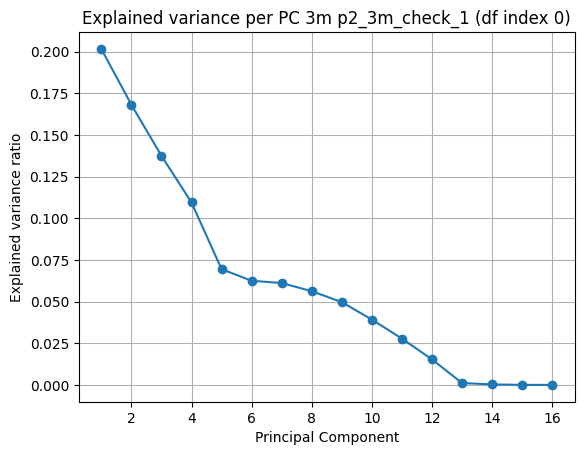

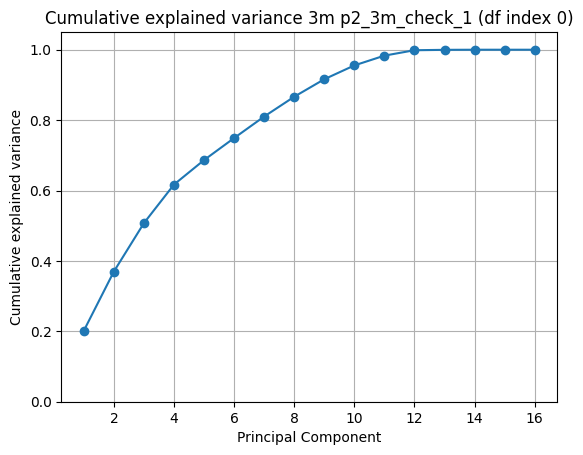

Requested k=20 is greater than available features (16). Using k=16.
Explained variance per component for 3m p2_3m_check_2:
  PC1: 0.2017
  PC2: 0.1682
  PC3: 0.1376
  PC4: 0.1095
  PC5: 0.0695
  PC6: 0.0625
  PC7: 0.0612
  PC8: 0.0563
  PC9: 0.0497
  PC10: 0.0392
  PC11: 0.0278
  PC12: 0.0153
  PC13: 0.0011
  PC14: 0.0003
  PC15: 0.0000
  PC16: 0.0000
Cumulative explained variance (k=16) for 3m p2_3m_check_2: 1.0000


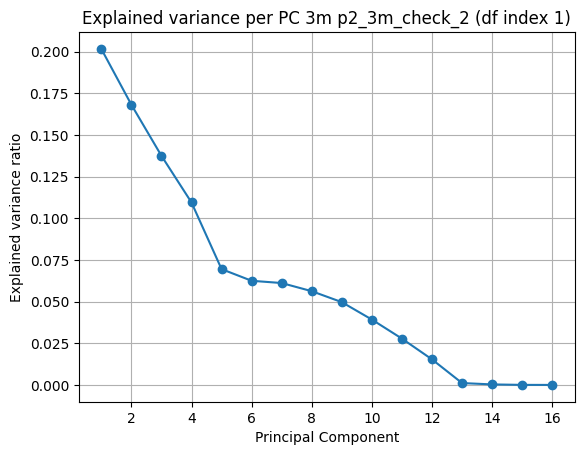

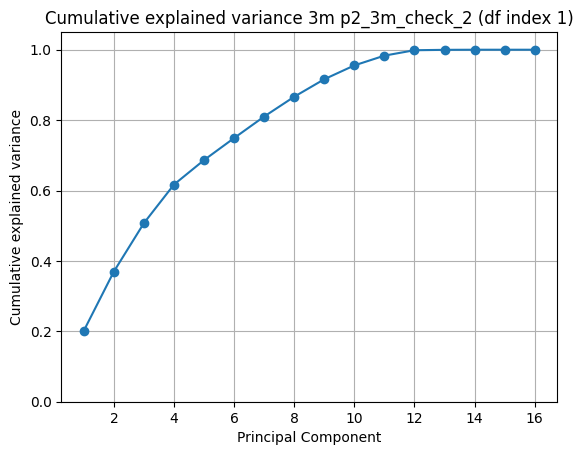

PCA pipeline failed for DataFrame at index 2: 
Requested k=20 is greater than available features (16). Using k=16.
PCA pipeline failed for DataFrame at index 3: 
Explained variance per component for 3m p2_3m_check_5:
  PC1: 0.1108
  PC2: 0.0730
  PC3: 0.0698
  PC4: 0.0658
  PC5: 0.0614
  PC6: 0.0578
  PC7: 0.0443
  PC8: 0.0411
  PC9: 0.0380
  PC10: 0.0371
  PC11: 0.0359
  PC12: 0.0335
  PC13: 0.0289
  PC14: 0.0283
  PC15: 0.0241
  PC16: 0.0226
  PC17: 0.0209
  PC18: 0.0206
  PC19: 0.0198
  PC20: 0.0183
Cumulative explained variance (k=20) for 3m p2_3m_check_5: 0.8520


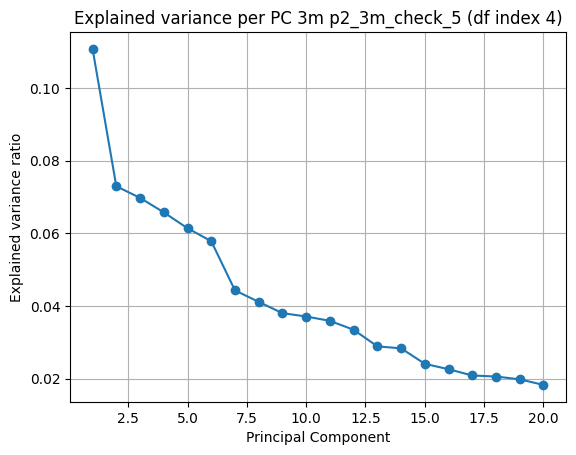

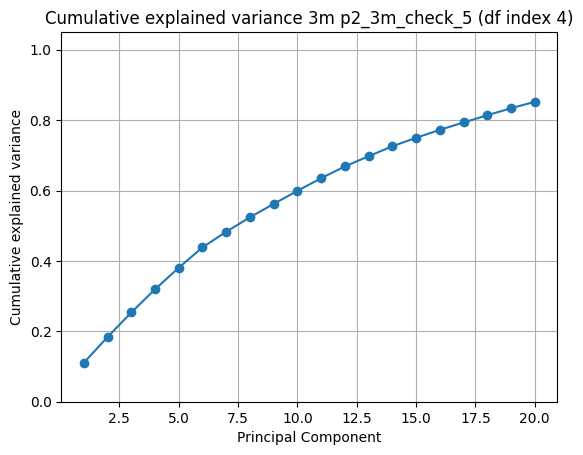

Requested k=20 is greater than available features (15). Using k=15.
PCA pipeline failed for DataFrame at index 0: 
Requested k=20 is greater than available features (15). Using k=15.
PCA pipeline failed for DataFrame at index 1: 
Requested k=20 is greater than available features (15). Using k=15.
PCA pipeline failed for DataFrame at index 2: 
PCA pipeline failed for DataFrame at index 3: 
Explained variance per component for 1y p2_1y_check_7:
  PC1: 0.1251
  PC2: 0.0922
  PC3: 0.0891
  PC4: 0.0677
  PC5: 0.0591
  PC6: 0.0547
  PC7: 0.0510
  PC8: 0.0485
  PC9: 0.0438
  PC10: 0.0396
  PC11: 0.0367
  PC12: 0.0315
  PC13: 0.0298
  PC14: 0.0281
  PC15: 0.0276
  PC16: 0.0257
  PC17: 0.0233
  PC18: 0.0215
  PC19: 0.0200
  PC20: 0.0182
Cumulative explained variance (k=20) for 1y p2_1y_check_7: 0.9332


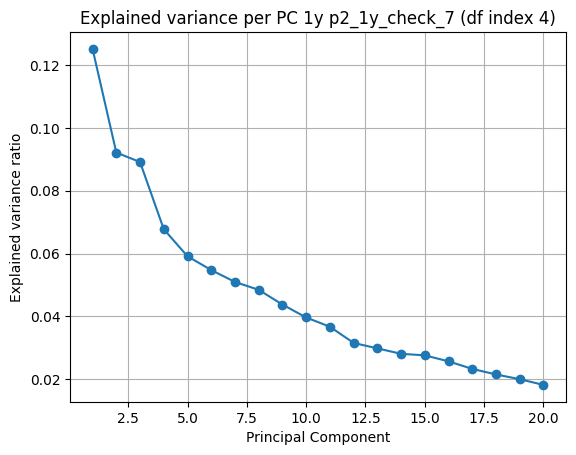

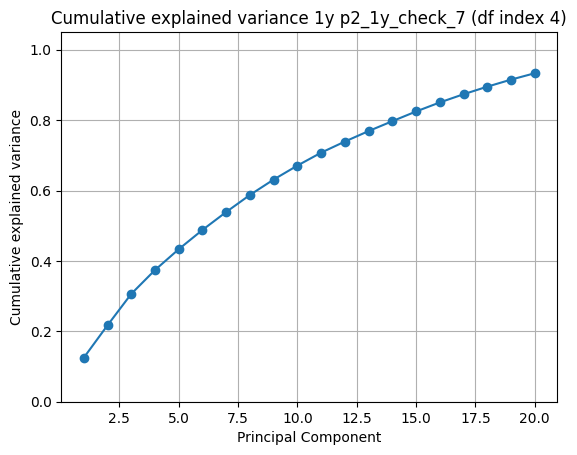

In [0]:
pca_dfs_3m = run_pca_pipeline(dfs_3m, PCA_columns, "3m", k=20, modifier_fn=three_month_modifier_for_pca, pca_feature_col="features_with_pca")
pca_dfs_1y = run_pca_pipeline(dfs_1y, PCA_1y, "1y", k=20, pca_feature_col="features_with_pca")

## Main Dataset creation

In [0]:
# Leveraged from Eric
def create_delay_groups(df):
    df_new = df.withColumn(
        "DEP_DELAY_GROUP_CLASSIFIED",
        when(col("DEP_DELAY_GROUP").isin(-2, -1), "not_delayed")
        .when(col("DEP_DELAY_GROUP").isin(0), "not_delayed")
        .otherwise("delayed"),
    )
    return df_new

In [0]:
def prep_for_rf(df, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    banned = {label_col, "DEP_DELAY_GROUP"}

    # 1) clear any stale ML metadata
    df = df.select([F.col(c).alias(c, metadata={}) for c in df.columns])

    # 2) normalize strings, then cast ALL non-label strings to double
    for c, t in df.dtypes:
        if t == "string" and c not in banned:
            df = df.withColumn(c, F.trim(F.col(c)))
            df = df.withColumn(c, F.when(F.col(c) == "", None).otherwise(F.col(c)))
            df = df.withColumn(c, F.col(c).cast("double"))  # non-numeric → null

    # 3) fill NaNs in numerics (so assembler/RF won’t choke)
    numeric_cols = [c for c, t in df.dtypes if c not in banned and t in {"double","float","int","bigint"}]
    if numeric_cols:
        df = df.fillna(0.0, subset=numeric_cols)
    else:
        raise ValueError("Still no numeric columns after casting — check schema/label name.")

    return df

In [0]:
def train_test_split(df):
    # Train / test split
    train_df, test_df = df.randomSplit([0.8, 0.2], seed=1234)
    return train_df, test_df

def month_split(df):
    """ month split where the first 3 qtrs are train/eval and last qtr is test/predict"""
    train_df = df.filter(month(to_timestamp(col("DATE"))) <= 9)
    test_df = df.filter(month(to_timestamp(col("DATE"))) >= 10)
    return train_df, test_df

def get_feature_cols(df, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    # Numeric feature columns only (excluding label and raw group)
    feature_cols = [
        c for c, t in df.dtypes
        if t in ("int", "bigint", "double", "float")
        and c not in [label_col, "DEP_DELAY_GROUP"]
    ]
    return feature_cols

def drop_columns(df, columns_to_drop):
    for col_name in columns_to_drop:
        df = df.drop(col_name)
    return df

In [0]:
def get_train_test_filter_df(
    item, split_fn, drop_cols, elected_cols=None, pca_col="features_with_pca"
):
    df = item["df"]
    name = item["name"]
    df_dg = create_delay_groups(df)
    df_clean = prep_for_rf(df_dg)
    # Only drop columns that exist, but never drop DEP_DELAY_GROUP_CLASSIFIED
    cols_to_drop = [col for col in drop_cols if col in df_clean.columns and col != "DEP_DELAY_GROUP_CLASSIFIED"]
    df_filtered = drop_columns(df_clean, cols_to_drop)
    if elected_cols is not None:
        # Always include the PCA column if it exists and DEP_DELAY_GROUP_CLASSIFIED
        cols_to_select = []
        if pca_col in df_filtered.columns:
            pass
            # cols_to_select.append(pca_col). # Ignore PCA column vector due to memory issues
        cols_to_select += [c for c in elected_cols if c != pca_col and c in df_filtered.columns]
        if "DEP_DELAY_GROUP_CLASSIFIED" not in cols_to_select and "DEP_DELAY_GROUP_CLASSIFIED" in df_filtered.columns:
            cols_to_select.append("DEP_DELAY_GROUP_CLASSIFIED")
        df_filtered = df_filtered.select(*cols_to_select)
        feature_cols = [c for c in cols_to_select if c != "DEP_DELAY_GROUP_CLASSIFIED"]
    else:
        feature_cols = [c for c in df_filtered.columns if c != "DEP_DELAY_GROUP_CLASSIFIED"]
    train_df, test_df = split_fn(df_filtered)

    return {
        "name": name,
        "train_df": train_df.cache(),
        "test_df": test_df.cache(),
        "feature_cols": feature_cols
    }

def model_pipeline(df_list, split_fn, drop_cols=None, elected_cols=None):
    df_split = []
    if drop_cols is None:
        drop_cols = []

    for item in df_list:
        df_items = get_train_test_filter_df(item, split_fn, drop_cols, elected_cols)
        df_split.append(df_items)

    return df_split

### Dataset curating

In [0]:
for i, item in enumerate(dfs_1y):
    print(f"Column names for dfs_1y[{i}] ({item['name']}):")
    print(item["df"].columns)

for i, item in enumerate(dfs_3m):
    print(f"Column names for dfs_3m[{i}] ({item['name']}):")
    print(item["df"].columns)

Column names for dfs_1y[0] (p2_1y_check_1):
['HourlyPrecipitation', 'HourlyAltimeterSetting', 'ACTUAL_ELAPSED_TIME', 'DEP_DELAY_NEW', 'DEP_TIME', 'DEP_DELAY', 'DEP_DELAY_GROUP', 'HourlySkyConditions', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'TAIL_NUM', 'HourlyWindDirection', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyWindSpeed', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'REM', 'DEST_STATE_FIPS', 'SOURCE', 'LATITUDE', 'DATE', 'STATION', 'two_hours_prior_depart_UTC', 'four_hours_prior_depart_UTC', 'sched_depart_date_time_UTC', 'DEP_TIME_BLK', 'DIVERTED', 'CANCELLED', 'ARR_TIME_BLK', 'DISTANCE_GROUP', 'DISTANCE', 'CRS_ARR_TIME', 'DAY_OF_MONTH', 'ORIGIN_AIRPORT_ID', 'OP_CARRIER_FL_NUM', 'DEST_STATE_ABR', 'DEST_CITY_NAME', 'DEST', 'DEST_CITY_MARKET_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_STATE_NM', 'ORIGIN_WAC', 'ORIGIN_STATE_NM', 'CRS_DEP_TIME', 'DEST_WAC', 'REPORT_TYPE', 'NAME', 'ELEVATION', 'FLIGHTS', 'DEST_AIRPORT_ID', 'dest_station_id', 'dest_station_nam

In [0]:
df_split = model_pipeline(pca_dfs_3m, train_test_split, cols_to_remove, target_selected)
df_split_1y = model_pipeline(pca_dfs_1y, month_split, cols_to_remove, target_selected)

In [0]:
for i, item in enumerate(df_split):
    print(f"Column names for dfs_1y[{i}] ({item['name']}):")
    print(item["train_df"].columns)
    print(f"First 5 rows of train_df for dfs_1y[{i}] ({item['name']}):")
    display(item["train_df"].limit(5))

for i, item in enumerate(df_split_1y):
    print(f"Column names for dfs_3m[{i}] ({item['name']}):")
    print(item["train_df"].columns)
    print(f"First 5 rows of train_df for dfs_3m[{i}] ({item['name']}):")
    display(item["train_df"].limit(5))

Column names for dfs_1y[0] (p2_3m_check_1):
['HourlyDryBulbTemperature', 'OP_CARRIER_FL_NUM', 'dest_airport_lat', 'origin_airport_lat', 'DISTANCE', 'DEST_AIRPORT_ID', 'HourlyWindDirection', 'LONGITUDE', 'LATITUDE', 'DAY_OF_MONTH', 'QUARTER', 'ORIGIN_AIRPORT_ID', 'ELEVATION', 'dest_airport_lon', 'HourlyVisibility', 'HourlyPrecipitation', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting', 'HourlyRelativeHumidity', 'HourlyWindSpeed', 'DEP_DELAY_GROUP_CLASSIFIED']
First 5 rows of train_df for dfs_1y[0] (p2_3m_check_1):


HourlyDryBulbTemperature,OP_CARRIER_FL_NUM,dest_airport_lat,origin_airport_lat,DISTANCE,DEST_AIRPORT_ID,HourlyWindDirection,LONGITUDE,LATITUDE,DAY_OF_MONTH,QUARTER,ORIGIN_AIRPORT_ID,ELEVATION,dest_airport_lon,HourlyVisibility,HourlyPrecipitation,HourlyWetBulbTemperature,HourlyAltimeterSetting,HourlyRelativeHumidity,HourlyWindSpeed,DEP_DELAY_GROUP_CLASSIFIED
-40.0,130.0,47.4,64.8,1533.0,14747.0,20.0,-147.8761,64.8039,7.0,1.0,11630.0,131.7,-122.3,1.5,0.0,0.0,29.84,0.0,3.0,not_delayed
-40.0,130.0,47.4,64.8,1533.0,14747.0,310.0,-147.8761,64.8039,26.0,1.0,11630.0,131.7,-122.3,6.0,0.0,0.0,30.28,0.0,3.0,delayed
-39.0,50.0,71.3,70.2,204.0,10754.0,240.0,-148.4772,70.1917,12.0,1.0,14709.0,18.6,-156.8,10.0,0.0,0.0,30.2,0.0,8.0,not_delayed
-39.0,50.0,71.3,70.2,204.0,10754.0,250.0,-148.4772,70.1917,11.0,1.0,14709.0,18.6,-156.8,10.0,0.0,0.0,30.39,0.0,7.0,delayed
-38.0,50.0,71.3,70.2,204.0,10754.0,250.0,-148.4772,70.1917,4.0,1.0,14709.0,18.6,-156.8,10.0,0.0,0.0,30.65,0.0,9.0,not_delayed


Column names for dfs_1y[1] (p2_3m_check_2):
['HourlyDryBulbTemperature', 'OP_CARRIER_FL_NUM', 'dest_airport_lat', 'origin_airport_lat', 'DISTANCE', 'DEST_AIRPORT_ID', 'HourlyWindDirection', 'LONGITUDE', 'LATITUDE', 'DAY_OF_MONTH', 'QUARTER', 'ORIGIN_AIRPORT_ID', 'ELEVATION', 'dest_airport_lon', 'HourlyVisibility', 'HourlyPrecipitation', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting', 'HourlyRelativeHumidity', 'HourlyWindSpeed', 'DEP_DELAY_GROUP_CLASSIFIED']
First 5 rows of train_df for dfs_1y[1] (p2_3m_check_2):


HourlyDryBulbTemperature,OP_CARRIER_FL_NUM,dest_airport_lat,origin_airport_lat,DISTANCE,DEST_AIRPORT_ID,HourlyWindDirection,LONGITUDE,LATITUDE,DAY_OF_MONTH,QUARTER,ORIGIN_AIRPORT_ID,ELEVATION,dest_airport_lon,HourlyVisibility,HourlyPrecipitation,HourlyWetBulbTemperature,HourlyAltimeterSetting,HourlyRelativeHumidity,HourlyWindSpeed,DEP_DELAY_GROUP_CLASSIFIED
-40.0,55.0,71.3,70.2,204.0,10754.0,240.0,-148.4772,70.1917,12.0,1.0,14709.0,18.6,-156.8,8.0,0.0,0.0,30.2,0.0,8.0,not_delayed
-40.0,130.0,47.4,64.8,1533.0,14747.0,0.0,-147.8761,64.8039,27.0,1.0,11630.0,131.7,-122.3,2.0,0.0,0.0,30.18,0.0,0.0,delayed
-40.0,130.0,47.4,64.8,1533.0,14747.0,20.0,-147.8761,64.8039,7.0,1.0,11630.0,131.7,-122.3,1.5,0.0,0.0,29.84,0.0,3.0,not_delayed
-40.0,130.0,47.4,64.8,1533.0,14747.0,310.0,-147.8761,64.8039,26.0,1.0,11630.0,131.7,-122.3,6.0,0.0,0.0,30.28,0.0,3.0,delayed
-39.0,50.0,71.3,70.2,204.0,10754.0,240.0,-148.4772,70.1917,12.0,1.0,14709.0,18.6,-156.8,10.0,0.0,0.0,30.2,0.0,8.0,not_delayed


Column names for dfs_1y[2] (p2_3m_check_3):
['HourlyDryBulbTemperature', 'OP_CARRIER_FL_NUM', 'dest_airport_lat', 'origin_airport_lat', 'DISTANCE', 'HourlyPrecipitation_was_missing', 'DEST_AIRPORT_ID', 'HourlyWindDirection', 'LONGITUDE', 'LATITUDE', 'DAY_OF_MONTH', 'QUARTER', 'ORIGIN_AIRPORT_ID', 'ELEVATION', 'dest_airport_lon', 'HourlyVisibility', 'HourlyPrecipitation', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting', 'HourlyRelativeHumidity', 'wind_deg_imputed', 'HourlyWindSpeed', 'wind_dir_sin', 'DEP_DELAY_GROUP_CLASSIFIED']
First 5 rows of train_df for dfs_1y[2] (p2_3m_check_3):


HourlyDryBulbTemperature,OP_CARRIER_FL_NUM,dest_airport_lat,origin_airport_lat,DISTANCE,HourlyPrecipitation_was_missing,DEST_AIRPORT_ID,HourlyWindDirection,LONGITUDE,LATITUDE,DAY_OF_MONTH,QUARTER,ORIGIN_AIRPORT_ID,ELEVATION,dest_airport_lon,HourlyVisibility,HourlyPrecipitation,HourlyWetBulbTemperature,HourlyAltimeterSetting,HourlyRelativeHumidity,wind_deg_imputed,HourlyWindSpeed,wind_dir_sin,DEP_DELAY_GROUP_CLASSIFIED
-40.0,55.0,71.3,70.2,204.0,0,10754.0,240.0,-148.4772,70.1917,12.0,1.0,14709.0,18.6,-156.8,8.0,0.0,-18.0,30.2,66.0,240.0,8.0,-0.866,not_delayed
-39.0,50.0,71.3,70.2,204.0,0,10754.0,240.0,-148.4772,70.1917,12.0,1.0,14709.0,18.6,-156.8,10.0,0.0,-23.0,30.2,69.0,240.0,8.0,-0.866,not_delayed
-39.0,50.0,71.3,70.2,204.0,0,10754.0,250.0,-148.4772,70.1917,11.0,1.0,14709.0,18.6,-156.8,10.0,0.0,-23.0,30.39,69.0,250.0,7.0,-0.9397,delayed
-38.0,50.0,71.3,70.2,204.0,0,10754.0,250.0,-148.4772,70.1917,4.0,1.0,14709.0,18.6,-156.8,10.0,0.0,-24.0,30.65,68.0,250.0,9.0,-0.9397,not_delayed
-37.0,51.0,61.2,70.2,627.0,0,10299.0,230.0,-148.4772,70.1917,13.0,1.0,14709.0,18.6,-150.0,10.0,0.0,-23.0,30.06,69.0,230.0,10.0,-0.766,not_delayed


Column names for dfs_1y[3] (p2_3m_check_4):
['HourlyDryBulbTemperature', 'OP_CARRIER_FL_NUM', 'dest_airport_lat', 'origin_airport_lat', 'DISTANCE', 'DEST_AIRPORT_ID', 'HourlyWindDirection', 'LONGITUDE', 'LATITUDE', 'DAY_OF_MONTH', 'QUARTER', 'ORIGIN_AIRPORT_ID', 'ELEVATION', 'dest_airport_lon', 'HourlyVisibility', 'HourlyPrecipitation', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting', 'HourlyRelativeHumidity', 'HourlyWindSpeed', 'DEP_DELAY_GROUP_CLASSIFIED']
First 5 rows of train_df for dfs_1y[3] (p2_3m_check_4):


HourlyDryBulbTemperature,OP_CARRIER_FL_NUM,dest_airport_lat,origin_airport_lat,DISTANCE,DEST_AIRPORT_ID,HourlyWindDirection,LONGITUDE,LATITUDE,DAY_OF_MONTH,QUARTER,ORIGIN_AIRPORT_ID,ELEVATION,dest_airport_lon,HourlyVisibility,HourlyPrecipitation,HourlyWetBulbTemperature,HourlyAltimeterSetting,HourlyRelativeHumidity,HourlyWindSpeed,DEP_DELAY_GROUP_CLASSIFIED
-37.0,51.0,61.2,70.2,627.0,10299.0,230.0,-148.4772,70.1917,13.0,1.0,14709.0,18.6,-150.0,10.0,0.0,0.0,30.06,0.0,10.0,not_delayed
-34.0,62.0,61.2,64.8,261.0,10299.0,0.0,-147.8761,64.8039,4.0,4.0,11630.0,131.7,-150.0,9.0,0.0,0.0,30.68,0.0,0.0,not_delayed
-34.0,126.0,47.4,64.8,1533.0,14747.0,0.0,-147.8761,64.8039,4.0,4.0,11630.0,131.7,-122.3,9.0,0.0,0.0,30.68,0.0,0.0,not_delayed
-34.0,126.0,47.4,64.8,1533.0,14747.0,0.0,-147.8761,64.8039,15.0,1.0,11630.0,131.7,-122.3,10.0,0.0,0.0,29.6,0.0,0.0,not_delayed
-34.0,184.0,47.4,64.8,1533.0,14747.0,0.0,-147.8761,64.8039,11.0,1.0,11630.0,131.7,-122.3,7.0,0.0,0.0,29.39,0.0,0.0,not_delayed


Column names for dfs_1y[4] (p2_3m_check_5):
['day_of_week', 'has_SCT', 'HourlyDryBulbTemperature', 'is_us_holiday', 'OP_CARRIER_FL_NUM', 'is_summer_peak', 'hour_of_day', 'CLR_height_ft', 'dest_airport_lat', 'BKN_height_ft', 'origin_airport_lat', 'DISTANCE', 'HourlyPrecipitation_was_missing', 'DEST_AIRPORT_ID', 'HourlyWindDirection', 'LONGITUDE', 'LATITUDE', 'DAY_OF_MONTH', 'QUARTER', 'ORIGIN_AIRPORT_ID', 'ELEVATION', 'has_OVC', 'dest_airport_lon', 'has_CLR', 'HourlyVisibility', 'has_FEW', 'SCT_height_ft', 'HourlyPrecipitation', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting', 'is_weekend', 'season', 'FEW_height_ft', 'OVC_height_ft', 'is_holiday_window', 'has_BKN', 'HourlyRelativeHumidity', 'wind_deg_imputed', 'HourlyWindSpeed', 'wind_dir_sin', 'DEP_DELAY_GROUP_CLASSIFIED']
First 5 rows of train_df for dfs_1y[4] (p2_3m_check_5):


day_of_week,has_SCT,HourlyDryBulbTemperature,is_us_holiday,OP_CARRIER_FL_NUM,is_summer_peak,hour_of_day,CLR_height_ft,dest_airport_lat,BKN_height_ft,origin_airport_lat,DISTANCE,HourlyPrecipitation_was_missing,DEST_AIRPORT_ID,HourlyWindDirection,LONGITUDE,LATITUDE,DAY_OF_MONTH,QUARTER,ORIGIN_AIRPORT_ID,ELEVATION,has_OVC,dest_airport_lon,has_CLR,HourlyVisibility,has_FEW,SCT_height_ft,HourlyPrecipitation,HourlyWetBulbTemperature,HourlyAltimeterSetting,is_weekend,season,FEW_height_ft,OVC_height_ft,is_holiday_window,has_BKN,HourlyRelativeHumidity,wind_deg_imputed,HourlyWindSpeed,wind_dir_sin,DEP_DELAY_GROUP_CLASSIFIED
1,0,-34.0,0,55.0,0,10,0,71.3,0,70.2,204.0,0,10754.0,200,-148.4772,70.1917,9.0,1.0,14709.0,18.6,0,-156.8,0,10.0,0,0,0.0,-23.0,30.48,0,0.0,0,0,0,0,69.0,200.0,8.0,-0.34202014332566866,not_delayed
1,0,-29.0,0,50.0,0,17,0,71.3,0,70.2,204.0,0,10754.0,240,-148.4772,70.1917,9.0,1.0,14709.0,18.6,0,-156.8,0,10.0,1,0,0.0,-29.0,30.48,0,0.0,7500,0,0,0,64.0,240.0,10.0,-0.8660254037844384,not_delayed
1,0,-27.0,0,153.0,0,19,0,64.5,0,66.9,183.0,0,13873.0,60,-162.6333,66.8667,26.0,1.0,13970.0,9.1,0,-165.4,0,10.0,0,0,0.0,-27.0,30.29,0,0.0,0,0,0,0,72.0,60.0,3.0,0.8660254037844386,not_delayed
1,0,-26.0,0,154.0,0,9,0,61.2,0,66.9,548.0,0,10299.0,60,-162.6333,66.8667,26.0,1.0,13970.0,9.1,0,-150.0,0,10.0,0,0,0.0,-26.0,30.31,0,0.0,0,0,0,0,72.0,60.0,5.0,0.8660254037844386,not_delayed
1,0,-25.0,0,50.0,0,17,0,71.3,3200,70.2,204.0,1,10754.0,240,-148.4772,70.1917,26.0,1.0,14709.0,18.6,1,-156.8,0,1.75,0,0,0.005,-25.0,30.2,0,0.0,0,4500,0,1,72.0,240.0,24.0,-0.8660254037844384,not_delayed


Column names for dfs_3m[0] (p2_1y_check_1):
['HourlyDryBulbTemperature', 'OP_CARRIER_FL_NUM', 'dest_airport_lat', 'origin_airport_lat', 'DISTANCE', 'DEST_AIRPORT_ID', 'HourlyWindDirection', 'LONGITUDE', 'LATITUDE', 'DAY_OF_MONTH', 'QUARTER', 'ORIGIN_AIRPORT_ID', 'ELEVATION', 'dest_airport_lon', 'HourlyVisibility', 'HourlyPrecipitation', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting', 'HourlyRelativeHumidity', 'HourlyWindSpeed', 'DEP_DELAY_GROUP_CLASSIFIED']
First 5 rows of train_df for dfs_3m[0] (p2_1y_check_1):


HourlyDryBulbTemperature,OP_CARRIER_FL_NUM,dest_airport_lat,origin_airport_lat,DISTANCE,DEST_AIRPORT_ID,HourlyWindDirection,LONGITUDE,LATITUDE,DAY_OF_MONTH,QUARTER,ORIGIN_AIRPORT_ID,ELEVATION,dest_airport_lon,HourlyVisibility,HourlyPrecipitation,HourlyWetBulbTemperature,HourlyAltimeterSetting,HourlyRelativeHumidity,HourlyWindSpeed,DEP_DELAY_GROUP_CLASSIFIED
41.0,14,40.6,33.8,2465.0,12478,0.0,-118.1463,33.8116,1,1,12954,9.4,-73.8,6.0,0.0,38.0,30.14,79.0,0.0,not_delayed
27.0,17,47.4,40.7,2402.0,14747,240.0,-74.1694,40.6825,1,1,11618,2.1,-122.3,10.0,0.0,22.0,30.18,46.0,9.0,not_delayed
46.0,20,42.4,32.7,2588.0,10721,0.0,-117.1831,32.7336,1,1,14679,4.6,-71.0,10.0,0.0,40.0,30.14,58.0,0.0,not_delayed
31.0,105,43.6,39.2,452.0,14321,250.0,-76.684,39.1733,1,1,10821,47.5,-70.3,10.0,0.0,27.0,30.09,64.0,6.0,not_delayed
37.0,115,25.8,33.9,2342.0,13303,80.0,-118.3888,33.938,1,1,12892,29.6,-80.3,10.0,0.0,32.0,30.11,59.0,7.0,not_delayed


Column names for dfs_3m[1] (p2_1y_check_2):
['HourlyDryBulbTemperature', 'OP_CARRIER_FL_NUM', 'dest_airport_lat', 'origin_airport_lat', 'DISTANCE', 'DEST_AIRPORT_ID', 'HourlyWindDirection', 'LONGITUDE', 'LATITUDE', 'DAY_OF_MONTH', 'QUARTER', 'ORIGIN_AIRPORT_ID', 'ELEVATION', 'dest_airport_lon', 'HourlyVisibility', 'HourlyPrecipitation', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting', 'HourlyRelativeHumidity', 'HourlyWindSpeed', 'DEP_DELAY_GROUP_CLASSIFIED']
First 5 rows of train_df for dfs_3m[1] (p2_1y_check_2):


HourlyDryBulbTemperature,OP_CARRIER_FL_NUM,dest_airport_lat,origin_airport_lat,DISTANCE,DEST_AIRPORT_ID,HourlyWindDirection,LONGITUDE,LATITUDE,DAY_OF_MONTH,QUARTER,ORIGIN_AIRPORT_ID,ELEVATION,dest_airport_lon,HourlyVisibility,HourlyPrecipitation,HourlyWetBulbTemperature,HourlyAltimeterSetting,HourlyRelativeHumidity,HourlyWindSpeed,DEP_DELAY_GROUP_CLASSIFIED
40.0,8,40.7,47.4,2402.0,11618,20.0,-122.3138,47.4444,1,1,14747,112.8,-74.2,10.0,0.0,34.0,30.28,53.0,5.0,not_delayed
31.0,15,37.6,40.6,2586.0,14771,270.0,-73.76401,40.63915,1,1,12478,3.4,-122.4,10.0,0.0,24.0,30.19,36.0,11.0,not_delayed
51.0,29,32.9,34.1,1188.0,11298,260.0,-117.60028,34.05611,1,1,13891,289.3,-97.0,10.0,0.0,40.0,30.09,35.0,3.0,delayed
40.0,32,39.9,47.4,2378.0,14100,20.0,-122.3138,47.4444,1,1,14747,112.8,-75.2,10.0,0.0,34.0,30.28,53.0,5.0,not_delayed
31.0,46,37.6,40.6,2586.0,14771,270.0,-73.76401,40.63915,1,1,12478,3.4,-122.4,10.0,0.0,24.0,30.19,36.0,11.0,not_delayed


Column names for dfs_3m[2] (p2_1y_check_4):
['HourlyDryBulbTemperature', 'OP_CARRIER_FL_NUM', 'dest_airport_lat', 'origin_airport_lat', 'DISTANCE', 'DEST_AIRPORT_ID', 'HourlyWindDirection', 'LONGITUDE', 'LATITUDE', 'DAY_OF_MONTH', 'QUARTER', 'ORIGIN_AIRPORT_ID', 'ELEVATION', 'dest_airport_lon', 'HourlyVisibility', 'HourlyPrecipitation', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting', 'HourlyRelativeHumidity', 'HourlyWindSpeed', 'DEP_DELAY_GROUP_CLASSIFIED']
First 5 rows of train_df for dfs_3m[2] (p2_1y_check_4):


HourlyDryBulbTemperature,OP_CARRIER_FL_NUM,dest_airport_lat,origin_airport_lat,DISTANCE,DEST_AIRPORT_ID,HourlyWindDirection,LONGITUDE,LATITUDE,DAY_OF_MONTH,QUARTER,ORIGIN_AIRPORT_ID,ELEVATION,dest_airport_lon,HourlyVisibility,HourlyPrecipitation,HourlyWetBulbTemperature,HourlyAltimeterSetting,HourlyRelativeHumidity,HourlyWindSpeed,DEP_DELAY_GROUP_CLASSIFIED
40.0,8,40.7,47.4,2402.0,11618,20.0,-122.3138,47.4444,1,1,14747,112.8,-74.2,10.0,0.0,34.0,30.28,53.0,5.0,not_delayed
31.0,15,37.6,40.6,2586.0,14771,270.0,-73.76401,40.63915,1,1,12478,3.4,-122.4,10.0,0.0,24.0,30.19,36.0,11.0,not_delayed
51.0,29,32.9,34.1,1188.0,11298,260.0,-117.60028,34.05611,1,1,13891,289.3,-97.0,10.0,0.0,40.0,30.09,35.0,3.0,delayed
40.0,32,39.9,47.4,2378.0,14100,20.0,-122.3138,47.4444,1,1,14747,112.8,-75.2,10.0,0.0,34.0,30.28,53.0,5.0,not_delayed
31.0,46,37.6,40.6,2586.0,14771,270.0,-73.76401,40.63915,1,1,12478,3.4,-122.4,10.0,0.0,24.0,30.19,36.0,11.0,not_delayed


Column names for dfs_3m[3] (p2_1y_check_5):
['has_SCT', 'HourlyDryBulbTemperature', 'OP_CARRIER_FL_NUM', 'CLR_height_ft', 'dest_airport_lat', 'BKN_height_ft', 'origin_airport_lat', 'wind_deg_raw', 'DISTANCE', 'HourlyPrecipitation_was_missing', 'DEST_AIRPORT_ID', 'LONGITUDE', 'LATITUDE', 'DAY_OF_MONTH', 'QUARTER', 'ORIGIN_AIRPORT_ID', 'ELEVATION', 'has_OVC', 'dest_airport_lon', 'has_CLR', 'HourlyVisibility', 'has_FEW', 'SCT_height_ft', 'HourlyPrecipitation', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting', 'HourlyWindDirection_deg', 'FEW_height_ft', 'OVC_height_ft', 'has_BKN', 'HourlyRelativeHumidity', 'HourlyWindSpeed', 'wind_dir_sin', 'DEP_DELAY_GROUP_CLASSIFIED']
First 5 rows of train_df for dfs_3m[3] (p2_1y_check_5):


has_SCT,HourlyDryBulbTemperature,OP_CARRIER_FL_NUM,CLR_height_ft,dest_airport_lat,BKN_height_ft,origin_airport_lat,wind_deg_raw,DISTANCE,HourlyPrecipitation_was_missing,DEST_AIRPORT_ID,LONGITUDE,LATITUDE,DAY_OF_MONTH,QUARTER,ORIGIN_AIRPORT_ID,ELEVATION,has_OVC,dest_airport_lon,has_CLR,HourlyVisibility,has_FEW,SCT_height_ft,HourlyPrecipitation,HourlyWetBulbTemperature,HourlyAltimeterSetting,HourlyWindDirection_deg,FEW_height_ft,OVC_height_ft,has_BKN,HourlyRelativeHumidity,HourlyWindSpeed,wind_dir_sin,DEP_DELAY_GROUP_CLASSIFIED
0,17.0,5400,0,42.2,0,42.2,350,378.0,0,11433,-75.98,42.2068,10,1,10577,486.2,0,-83.3,0,5.0,0,0,0.0,16.0,30.07,350.0,0,0,0,92.0,11.0,-0.1736481776669304,not_delayed
0,2.0,5212,0,42.2,0,42.2,330,378.0,0,11433,-75.98,42.2068,16,1,10577,486.2,0,-83.3,0,10.0,0,0,0.0,0.0,30.0,330.0,0,0,0,59.0,5.0,-0.5000000000000004,delayed
0,77.0,5212,0,42.2,0,42.2,330,378.0,0,11433,-75.98,42.2068,15,2,10577,486.2,0,-83.3,0,10.0,0,0,0.0,70.0,29.95,330.0,0,0,0,71.0,6.0,-0.5000000000000004,delayed
0,76.0,5097,0,42.2,0,42.2,320,378.0,0,11433,-75.98,42.2068,5,3,10577,486.2,0,-83.3,0,10.0,0,0,0.0,61.0,30.16,320.0,0,0,0,42.0,9.0,-0.6427876096865396,not_delayed
0,62.0,4896,0,42.2,0,42.2,270,378.0,0,11433,-75.98,42.2068,11,3,10577,486.2,0,-83.3,0,10.0,0,0,0.0,57.0,30.17,270.0,0,0,0,75.0,3.0,-1.0,not_delayed


Column names for dfs_3m[4] (p2_1y_check_7):
['day_of_week', 'has_SCT', 'HourlyDryBulbTemperature', 'is_us_holiday', 'OP_CARRIER_FL_NUM', 'is_summer_peak', 'hour_of_day', 'CLR_height_ft', 'dest_airport_lat', 'BKN_height_ft', 'origin_airport_lat', 'DISTANCE', 'HourlyPrecipitation_was_missing', 'DEST_AIRPORT_ID', 'LONGITUDE', 'LATITUDE', 'DAY_OF_MONTH', 'QUARTER', 'ORIGIN_AIRPORT_ID', 'ELEVATION', 'has_OVC', 'dest_airport_lon', 'has_CLR', 'HourlyVisibility', 'has_FEW', 'SCT_height_ft', 'HourlyPrecipitation', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting', 'is_weekend', 'HourlyWindDirection_deg', 'season', 'FEW_height_ft', 'OVC_height_ft', 'is_holiday_window', 'has_BKN', 'HourlyRelativeHumidity', 'HourlyWindSpeed', 'wind_dir_sin', 'DEP_DELAY_GROUP_CLASSIFIED']
First 5 rows of train_df for dfs_3m[4] (p2_1y_check_7):


day_of_week,has_SCT,HourlyDryBulbTemperature,is_us_holiday,OP_CARRIER_FL_NUM,is_summer_peak,hour_of_day,CLR_height_ft,dest_airport_lat,BKN_height_ft,origin_airport_lat,DISTANCE,HourlyPrecipitation_was_missing,DEST_AIRPORT_ID,LONGITUDE,LATITUDE,DAY_OF_MONTH,QUARTER,ORIGIN_AIRPORT_ID,ELEVATION,has_OVC,dest_airport_lon,has_CLR,HourlyVisibility,has_FEW,SCT_height_ft,HourlyPrecipitation,HourlyWetBulbTemperature,HourlyAltimeterSetting,is_weekend,HourlyWindDirection_deg,season,FEW_height_ft,OVC_height_ft,is_holiday_window,has_BKN,HourlyRelativeHumidity,HourlyWindSpeed,wind_dir_sin,DEP_DELAY_GROUP_CLASSIFIED
4,0,4.0,0,5076,0,22,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,5,1,10577,486.2,0,-83.3,0,10.0,0,0,0.0,3.0,30.13,0,300.0,0.0,0,0,0,0,76.0,6.0,-0.8660254037844386,delayed
2,0,15.0,0,5212,0,22,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,17,1,10577,486.2,0,-83.3,0,10.0,0,0,0.0,12.0,29.78,0,10.0,0.0,0,0,1,0,59.0,6.0,0.17364817766693033,not_delayed
2,0,72.0,0,5097,1,19,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,21,3,10577,486.2,0,-83.3,0,10.0,0,0,0.0,66.0,29.7,0,350.0,0.0,0,0,0,0,71.0,15.0,-0.1736481776669304,not_delayed
5,0,65.0,0,4896,1,10,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,31,3,10577,486.2,0,-83.3,0,10.0,0,0,0.0,61.0,29.94,0,260.0,0.0,0,0,0,0,78.0,7.0,-0.984807753012208,not_delayed
7,0,58.0,0,5457,1,10,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,23,3,10577,486.2,0,-83.3,0,10.0,0,0,0.0,55.0,30.1,1,50.0,0.0,0,0,0,0,84.0,5.0,0.766044443118978,not_delayed


### Modeling

In [0]:
def train_random_forest(df_train, df_test, features_col, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    """
    Train a Random Forest classifier on the given dataframe.
    Returns (model, predictions).
    """
    stages = []

    # Index string label -> numeric label
    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="keep",
    )
    stages.append(label_indexer)

    # Assemble features if features_col is a list
    if isinstance(features_col, list):
        assembler = VectorAssembler(
            inputCols=features_col,
            outputCol="features",
            handleInvalid="keep",
        )
        stages.append(assembler)
        features_col_name = "features"
    else:
        features_col_name = features_col

    # Random Forest classifier
    rf = RandomForestClassifier(
        featuresCol=features_col_name,
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        numTrees=150,
        maxDepth=8,
        seed=42,
    )
    stages.append(rf)

    rf_pipeline = Pipeline(stages=stages)

    rf_model = rf_pipeline.fit(df_train)

    pred_test = rf_model.transform(df_test)

    return rf_model, pred_test

In [0]:
def train_xgboost(df_train, df_test, features_col, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    """
    Train an XGBoost classifier using xgboost.spark.SparkXGBClassifier
    on the given dataframe. Returns (model, predictions).
    """
    stages = []

    # Index string label -> numeric label
    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="keep",
    )
    stages.append(label_indexer)

    # Assemble features if features_col is a list
    if isinstance(features_col, list):
        assembler = VectorAssembler(
            inputCols=features_col,
            outputCol="features",
            handleInvalid="keep",
        )
        stages.append(assembler)
        features_col_name = "features"
    else:
        features_col_name = features_col

    # XGBoost classifier
    xgb = SparkXGBClassifier(
        features_col=features_col_name,
        label_col="label",
        max_depth=6,
        n_estimators=100,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0
    )
    stages.append(xgb)

    xgb_pipeline = Pipeline(stages=stages)

    xgb_model = xgb_pipeline.fit(df_train)

    pred_test = xgb_model.transform(df_test)

    return xgb_model, pred_test


In [0]:
def modeling_pipeline(df_items, modeling_fn, model_save_path="", model_name="", *adjust_fns):
    save_path = f"{model_save_path}/{model_name}"
    pred_test_save_path = f"{model_save_path}/{model_name}_pred_test"

    # Try to load model and predictions if they exist
    try:
        model = PipelineModel.load(save_path)
        pred_test = spark.read.parquet(pred_test_save_path)
        print(f"Loaded model from {save_path}")
        print(f"Loaded predictions from {pred_test_save_path}")
        return {
            "model": model,
            "pred_test": pred_test,
            "name": model_name
        }
    except Exception:
        pass

    train_df = df_items["train_df"]
    test_df = df_items["test_df"]
    feature_cols = df_items["feature_cols"]

    # Make any adjustments as needed
    for adjust_fn in adjust_fns:
        train_df, test_df = adjust_fn(train_df, test_df)

    model, pred_test = modeling_fn(train_df, test_df, feature_cols)

    if model_save_path != "" and model_name != "":
        print(f"Model saved to {save_path}")
        model.write().overwrite().save(save_path)
        pred_test.write.mode("overwrite").parquet(pred_test_save_path)
        print(f"Predictions saved to {pred_test_save_path}")

    return {
        "model": model,
        "pred_test": pred_test,
        "name": model_name
    }

In [0]:
def train_models(df_split, modeling_fn, model_prefix):
    models = []
    for i in range(len(df_split)):
        model = modeling_pipeline(
            df_split[i],
            modeling_fn,
            model_save_path=f"dbfs:/student-groups/Group_4_1/{model_prefix}",
            model_name=df_split[i]["name"]
        )
        models.append(model)
    return models

In [0]:
def delete_model_if_exists(model_save_path, model_name):
    save_path = f"{model_save_path}/{model_name}"
    pred_test_save_path = f"{model_save_path}/{model_name}_pred_test"
    # Remove model directory if exists
    try:
        dbutils.fs.rm(save_path, True)
        print(f"Deleted model directory: {save_path}")
    except Exception as e:
        print(f"Could not delete model directory: {save_path} ({e})")
    # Remove predictions directory if exists
    try:
        dbutils.fs.rm(pred_test_save_path, True)
        print(f"Deleted predictions directory: {pred_test_save_path}")
    except Exception as e:
        print(f"Could not delete predictions directory: {pred_test_save_path} ({e})")

In [0]:
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[4]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[4]["name"])


# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[4]["name"])

# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model1_1y", df_split_1y[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model2_1y", df_split_1y[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model3_1y", df_split_1y[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model4_1y", df_split_1y[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model5_1y", df_split_1y[4]["name"])

## model run - EXPERIMENTS

XG Boost

In [0]:
xg_models = train_models(df_split, train_xgboost, "xgboost_model")

2025-11-17 19:11:47,770 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-17 19:12:15,343 INFO XGBoost-PySpark: _fit Finished xgboost training!


Model saved to dbfs:/student-groups/Group_4_1/xgboost_model/p2_3m_check_1
Predictions saved to dbfs:/student-groups/Group_4_1/xgboost_model/p2_3m_check_1_pred_test


2025-11-17 19:12:32,333 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-17 19:12:54,288 INFO XGBoost-PySpark: _fit Finished xgboost training!


Model saved to dbfs:/student-groups/Group_4_1/xgboost_model/p2_3m_check_2
Predictions saved to dbfs:/student-groups/Group_4_1/xgboost_model/p2_3m_check_2_pred_test


2025-11-17 19:13:11,948 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-17 19:13:29,865 INFO XGBoost-PySpark: _fit Finished xgboost training!


Model saved to dbfs:/student-groups/Group_4_1/xgboost_model/p2_3m_check_3
Predictions saved to dbfs:/student-groups/Group_4_1/xgboost_model/p2_3m_check_3_pred_test


2025-11-17 19:14:05,082 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-17 19:17:41,879 INFO XGBoost-PySpark: _fit Finished xgboost training!


Model saved to dbfs:/student-groups/Group_4_1/xgboost_model/p2_3m_check_4
Predictions saved to dbfs:/student-groups/Group_4_1/xgboost_model/p2_3m_check_4_pred_test


2025-11-17 19:18:56,822 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-17 19:19:20,325 INFO XGBoost-PySpark: _fit Finished xgboost training!


Model saved to dbfs:/student-groups/Group_4_1/xgboost_model/p2_3m_check_5
Predictions saved to dbfs:/student-groups/Group_4_1/xgboost_model/p2_3m_check_5_pred_test


In [0]:
xg_models_1y = train_models(df_split_1y, train_xgboost, "xgboost_model_1y")

2025-11-17 19:19:47,930 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-17 19:23:04,096 INFO XGBoost-PySpark: _fit Finished xgboost training!


Model saved to dbfs:/student-groups/Group_4_1/xgboost_model_1y/p2_1y_check_1
Predictions saved to dbfs:/student-groups/Group_4_1/xgboost_model_1y/p2_1y_check_1_pred_test


2025-11-17 19:23:45,453 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-17 19:24:53,406 INFO XGBoost-PySpark: _fit Finished xgboost training!


Model saved to dbfs:/student-groups/Group_4_1/xgboost_model_1y/p2_1y_check_2
Predictions saved to dbfs:/student-groups/Group_4_1/xgboost_model_1y/p2_1y_check_2_pred_test


2025-11-17 19:25:41,935 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-17 19:26:49,524 INFO XGBoost-PySpark: _fit Finished xgboost training!


Model saved to dbfs:/student-groups/Group_4_1/xgboost_model_1y/p2_1y_check_4
Predictions saved to dbfs:/student-groups/Group_4_1/xgboost_model_1y/p2_1y_check_4_pred_test


2025-11-17 19:27:16,750 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-17 19:28:19,414 INFO XGBoost-PySpark: _fit Finished xgboost training!


Model saved to dbfs:/student-groups/Group_4_1/xgboost_model_1y/p2_1y_check_5
Predictions saved to dbfs:/student-groups/Group_4_1/xgboost_model_1y/p2_1y_check_5_pred_test


2025-11-17 19:28:47,036 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 1 workers with
	booster params: {'objective': 'binary:logistic', 'colsample_bytree': 0.8, 'device': 'cpu', 'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'subsample': 0.8, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-11-17 19:30:17,660 INFO XGBoost-PySpark: _fit Finished xgboost training!


Model saved to dbfs:/student-groups/Group_4_1/xgboost_model_1y/p2_1y_check_7
Predictions saved to dbfs:/student-groups/Group_4_1/xgboost_model_1y/p2_1y_check_7_pred_test


Random forest

In [0]:
rf_models = train_models(df_split, train_random_forest, "rf_model")

Model saved to dbfs:/student-groups/Group_4_1/rf_model/p2_3m_check_1
Predictions saved to dbfs:/student-groups/Group_4_1/rf_model/p2_3m_check_1_pred_test
Model saved to dbfs:/student-groups/Group_4_1/rf_model/p2_3m_check_2
Predictions saved to dbfs:/student-groups/Group_4_1/rf_model/p2_3m_check_2_pred_test
Model saved to dbfs:/student-groups/Group_4_1/rf_model/p2_3m_check_3
Predictions saved to dbfs:/student-groups/Group_4_1/rf_model/p2_3m_check_3_pred_test
Model saved to dbfs:/student-groups/Group_4_1/rf_model/p2_3m_check_4
Predictions saved to dbfs:/student-groups/Group_4_1/rf_model/p2_3m_check_4_pred_test
Model saved to dbfs:/student-groups/Group_4_1/rf_model/p2_3m_check_5
Predictions saved to dbfs:/student-groups/Group_4_1/rf_model/p2_3m_check_5_pred_test


In [0]:
rf_models_1y = train_models(df_split_1y, train_random_forest, "rf_model_1y")

Model saved to dbfs:/student-groups/Group_4_1/rf_model_1y/p2_1y_check_1
Predictions saved to dbfs:/student-groups/Group_4_1/rf_model_1y/p2_1y_check_1_pred_test
Model saved to dbfs:/student-groups/Group_4_1/rf_model_1y/p2_1y_check_2
Predictions saved to dbfs:/student-groups/Group_4_1/rf_model_1y/p2_1y_check_2_pred_test
Model saved to dbfs:/student-groups/Group_4_1/rf_model_1y/p2_1y_check_4
Predictions saved to dbfs:/student-groups/Group_4_1/rf_model_1y/p2_1y_check_4_pred_test
Model saved to dbfs:/student-groups/Group_4_1/rf_model_1y/p2_1y_check_5
Predictions saved to dbfs:/student-groups/Group_4_1/rf_model_1y/p2_1y_check_5_pred_test
Model saved to dbfs:/student-groups/Group_4_1/rf_model_1y/p2_1y_check_7
Predictions saved to dbfs:/student-groups/Group_4_1/rf_model_1y/p2_1y_check_7_pred_test


## Evaluation

In [0]:
def plot_confusion_matrix(predictions, indexer_model, title: str):
    """
    predictions: DataFrame with columns 'label' and 'prediction'
    indexer_model: fitted StringIndexerModel used for labels
    title: title for the heatmap
    """
    confusion_pd = predictions.select(['label', 'prediction']).toPandas()

    cm = confusion_matrix(confusion_pd['label'], confusion_pd['prediction'])

    label_names = indexer_model.labels

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [0]:
def evaluate_model(model, pred_test, title):
    evaluator_acc = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy",
    )

    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1",
    )

    evaluator_prec = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedPrecision",
    )

    evaluator_rec = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedRecall",
    )

    test_accuracy = evaluator_acc.evaluate(pred_test)
    test_f1 = evaluator_f1.evaluate(pred_test)
    test_precision = evaluator_prec.evaluate(pred_test)
    test_recall = evaluator_rec.evaluate(pred_test)

    print(f"=== {title} ===")
    print(f"Test accuracy : {test_accuracy:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")
    print(f"Test precision: {test_precision:.4f}")
    print(f"Test recall   : {test_recall:.4f}")

    indexer_model = model.stages[0]
    plot_confusion_matrix(
        pred_test,
        indexer_model=indexer_model,
        title=f"Confusion Matrix - {title}",
    )

=== XGBoost - p2_3m_check_1 ===
Test accuracy : 0.8010
Test F1-score: 0.7268
Test precision: 0.7746
Test recall   : 0.8010


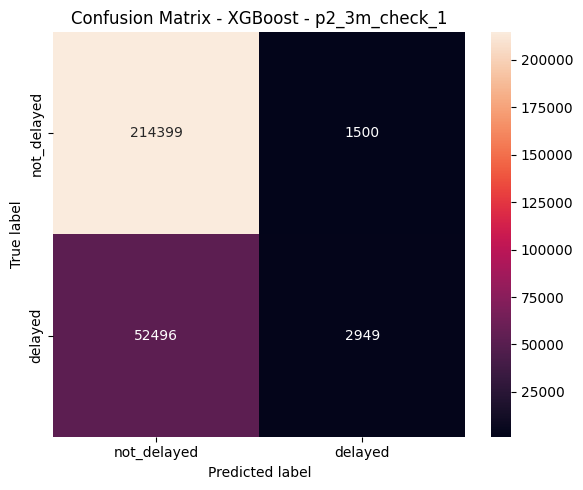

=== XGBoost - p2_3m_check_2 ===
Test accuracy : 0.8006
Test F1-score: 0.7265
Test precision: 0.7718
Test recall   : 0.8006


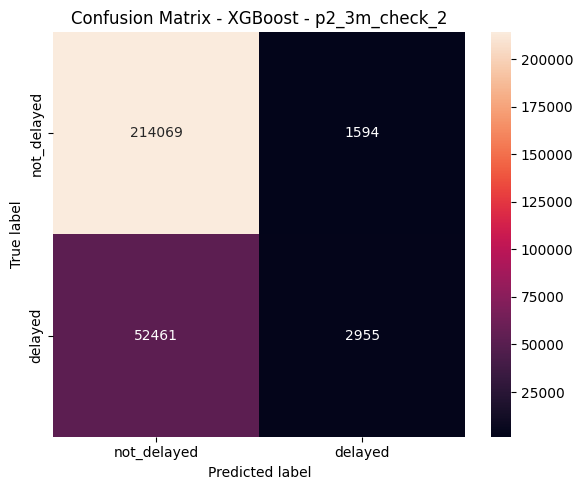

=== XGBoost - p2_3m_check_3 ===
Test accuracy : 0.8020
Test F1-score: 0.7292
Test precision: 0.7751
Test recall   : 0.8020


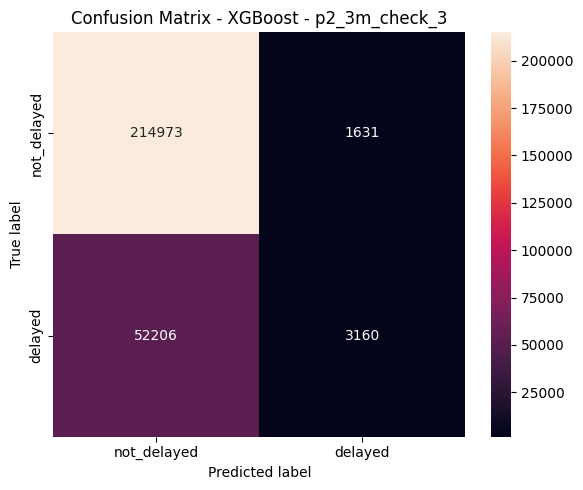

=== XGBoost - p2_3m_check_4 ===
Test accuracy : 0.8216
Test F1-score: 0.7423
Test precision: 0.7900
Test recall   : 0.8216


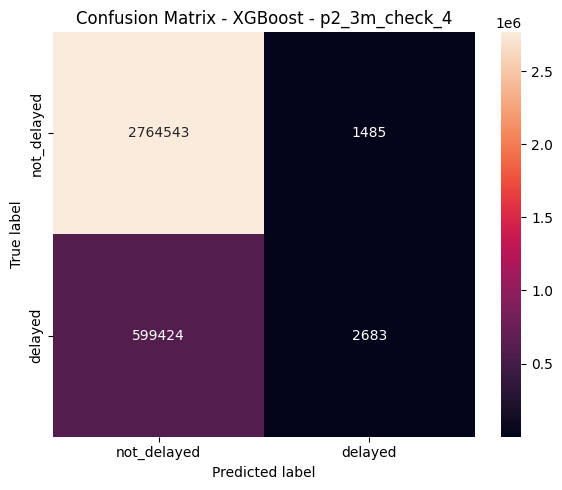

=== XGBoost - p2_3m_check_5 ===
Test accuracy : 0.8073
Test F1-score: 0.7469
Test precision: 0.7833
Test recall   : 0.8073


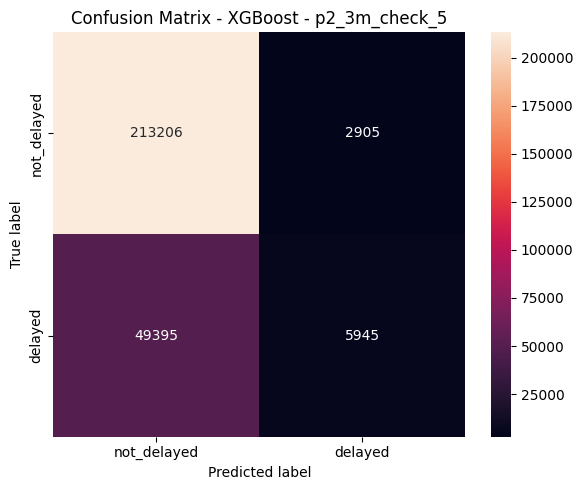

In [0]:
# XGBoost model evaluations
for model in xg_models:
    evaluate_model(model["model"], model["pred_test"], f"XGBoost - {model['name']}")

=== XGBoost 1y - p2_1y_check_1 ===
Test accuracy : 0.8426
Test F1-score: 0.7711
Test precision: 0.7853
Test recall   : 0.8426


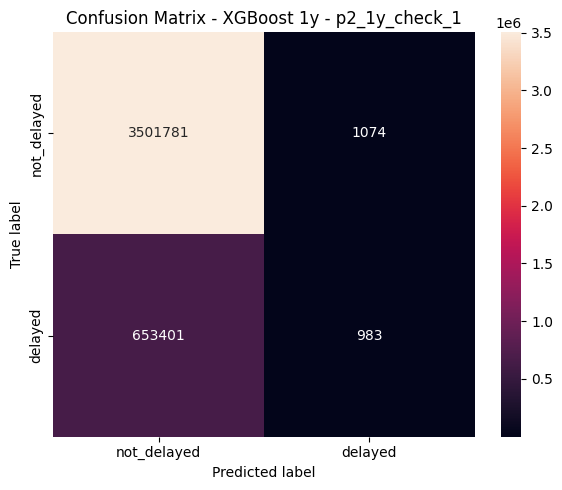

=== XGBoost 1y - p2_1y_check_2 ===
Test accuracy : 0.8395
Test F1-score: 0.7666
Test precision: 0.7856
Test recall   : 0.8395


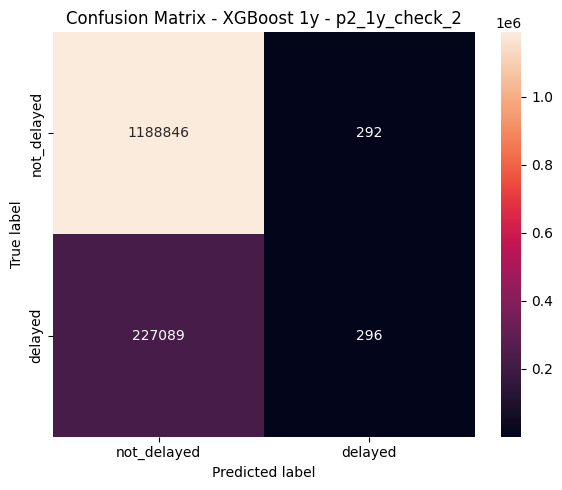

=== XGBoost 1y - p2_1y_check_4 ===
Test accuracy : 0.8395
Test F1-score: 0.7668
Test precision: 0.7847
Test recall   : 0.8395


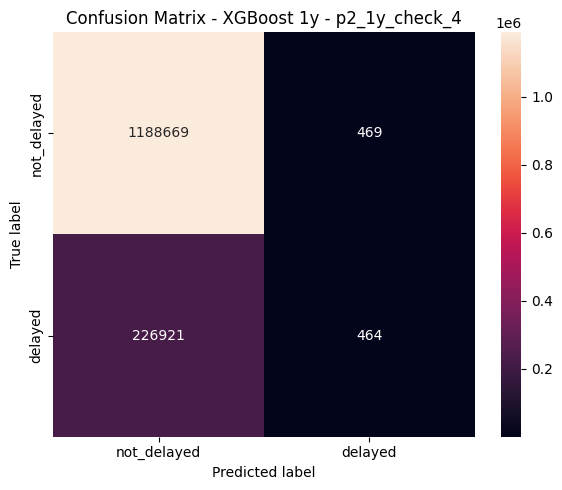

=== XGBoost 1y - p2_1y_check_5 ===
Test accuracy : 0.8440
Test F1-score: 0.7734
Test precision: 0.7722
Test recall   : 0.8440


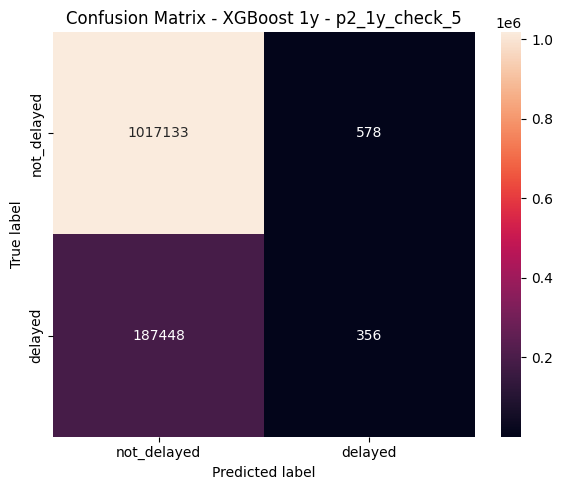

=== XGBoost 1y - p2_1y_check_7 ===
Test accuracy : 0.8442
Test F1-score: 0.7736
Test precision: 0.7894
Test recall   : 0.8442


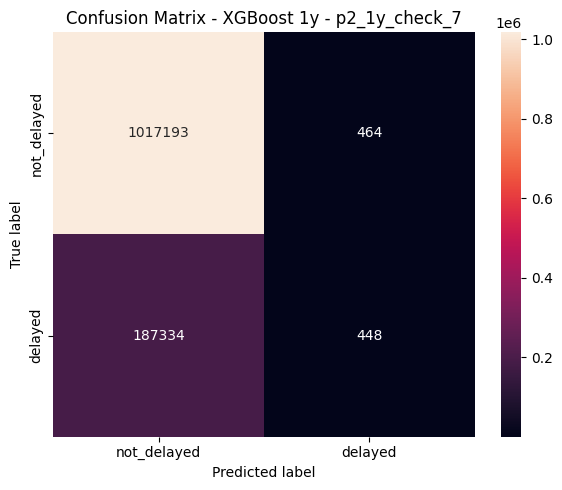

In [0]:
# XGBoost 1y model evaluations
for model in xg_models_1y:
    evaluate_model(model["model"], model["pred_test"], f"XGBoost 1y - {model['name']}")

=== Random Forest - p2_3m_check_1 ===
Test accuracy : 0.7970
Test F1-score: 0.7095
Test precision: 0.7864
Test recall   : 0.7970


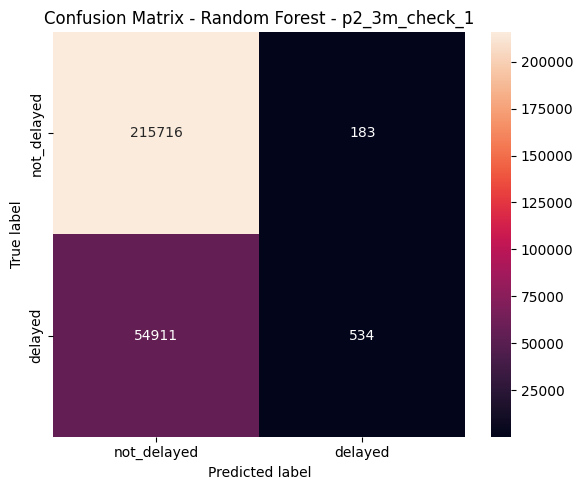

=== Random Forest - p2_3m_check_2 ===
Test accuracy : 0.7969
Test F1-score: 0.7095
Test precision: 0.7834
Test recall   : 0.7969


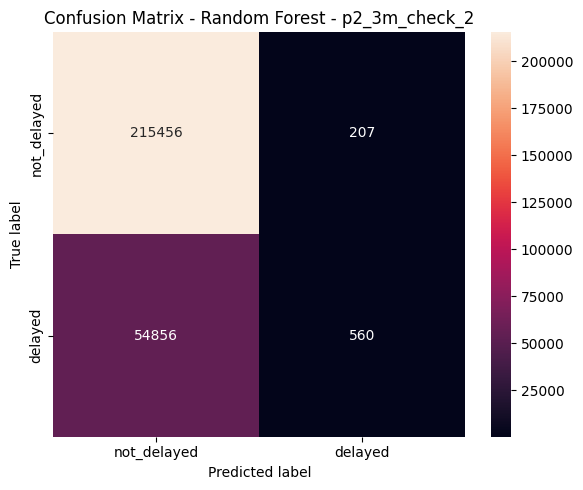

=== Random Forest - p2_3m_check_3 ===
Test accuracy : 0.7979
Test F1-score: 0.7111
Test precision: 0.7876
Test recall   : 0.7979


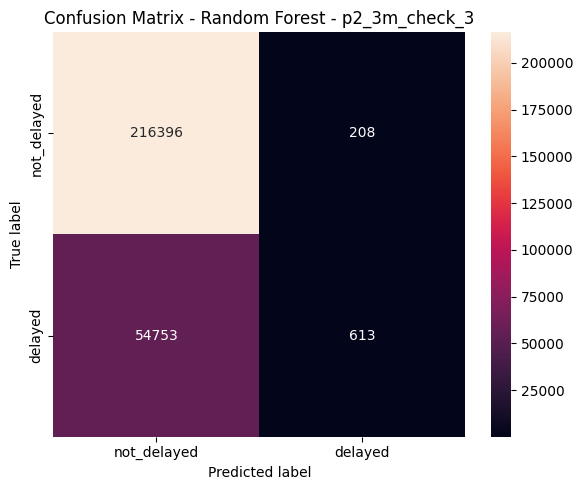

=== Random Forest - p2_3m_check_4 ===
Test accuracy : 0.8212
Test F1-score: 0.7406
Test precision: 0.6744
Test recall   : 0.8212


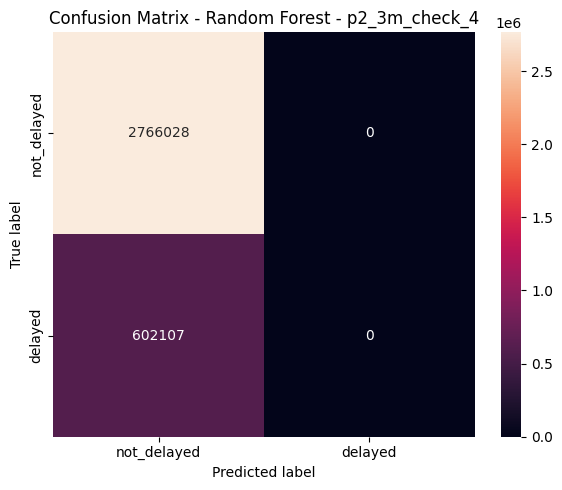

=== Random Forest - p2_3m_check_5 ===
Test accuracy : 0.7981
Test F1-score: 0.7119
Test precision: 0.7918
Test recall   : 0.7981


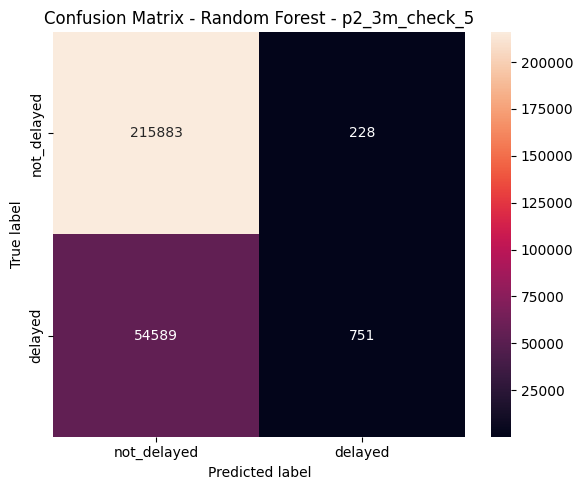

In [0]:
# Random Forest model evaluations
for model in rf_models:
    evaluate_model(model["model"], model["pred_test"], f"Random Forest - {model['name']}")

=== Random Forest 1y - p2_1y_check_1 ===
Test accuracy : 0.8426
Test F1-score: 0.7706
Test precision: 0.7100
Test recall   : 0.8426


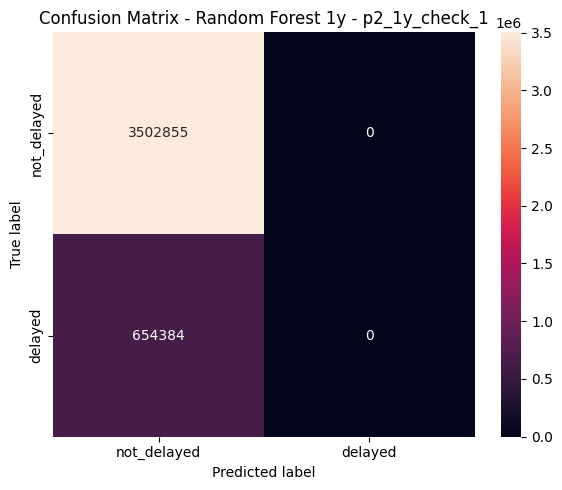

=== Random Forest 1y - p2_1y_check_2 ===
Test accuracy : 0.8395
Test F1-score: 0.7662
Test precision: 0.7047
Test recall   : 0.8395


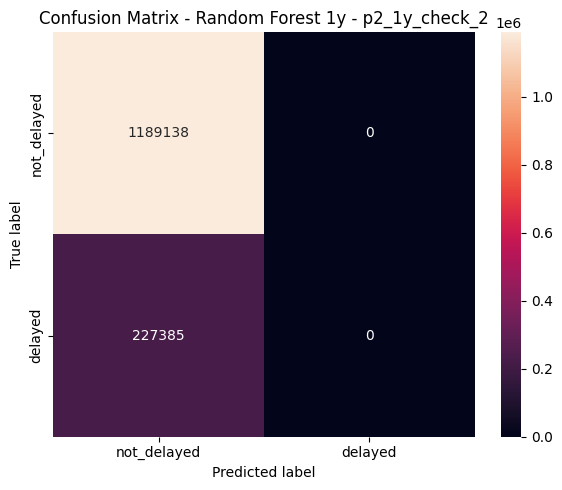

=== Random Forest 1y - p2_1y_check_4 ===
Test accuracy : 0.8395
Test F1-score: 0.7662
Test precision: 0.7047
Test recall   : 0.8395


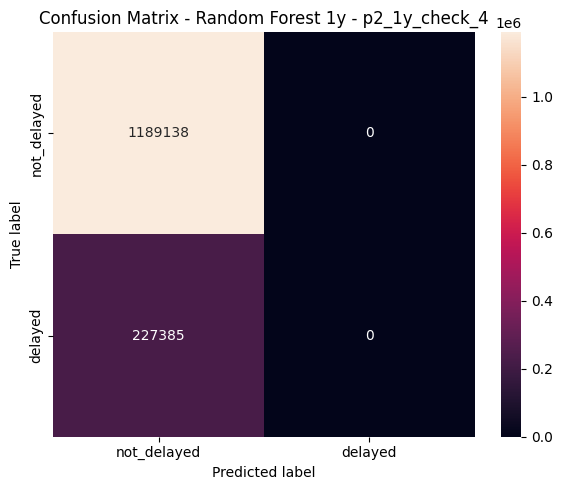

=== Random Forest 1y - p2_1y_check_5 ===
Test accuracy : 0.8442
Test F1-score: 0.7729
Test precision: 0.7127
Test recall   : 0.8442


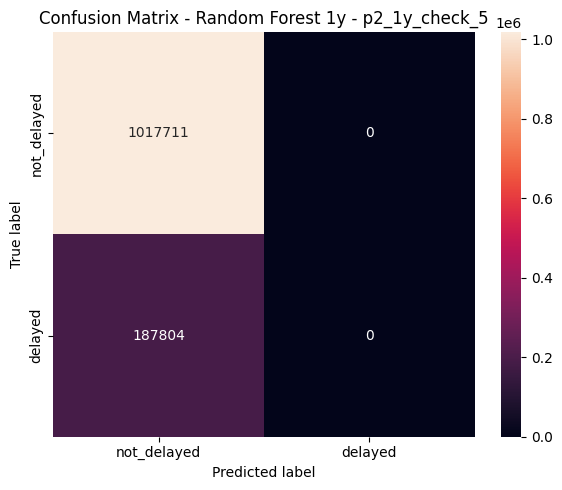

=== Random Forest 1y - p2_1y_check_7 ===
Test accuracy : 0.8442
Test F1-score: 0.7729
Test precision: 0.7127
Test recall   : 0.8442


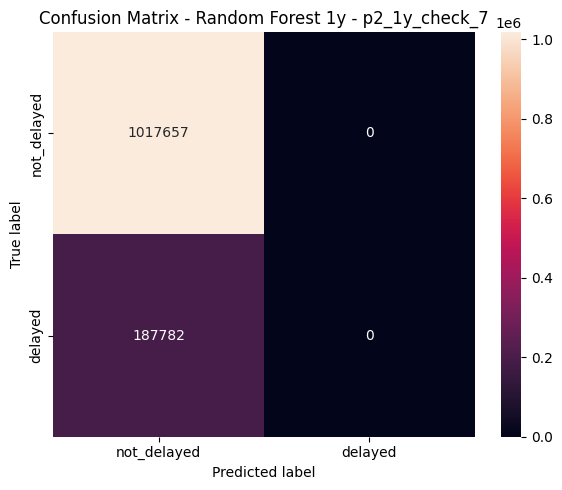

In [0]:
# Random Forest 1y model evaluations
for model in rf_models_1y:
    evaluate_model(model["model"], model["pred_test"], f"Random Forest 1y - {model['name']}")

Grid Search optimizations